In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import itertools, os, sys

sys.path.append('..')
from data.load_data import *
from src.map import *
from src.robot import *
from src.slam import *
from src.utils import *

In [2]:
import pickle

MAP_XLIM = (-15, 15)
MAP_YLIM = (-15, 15)
MAP_RESOLUTION = 0.05

belief = 0.8
MAP_LOGODDS_OCCUPIED_DIFF = np.log(belief/(1-belief))
MAP_LOGODDS_FREE_DIFF = np.log((1-belief)/belief)*.5
MAP_LOGODDS_LIM = (-100, 100)

N_PARTICLES = 128
N_EFF_THRESHOLD = 4
PREDICT_NOISE_SIGMA = np.diag([1e-3, 1e-3, 1e-3])
MAP_LOGODDS_OCCUPIED_THRESHOLD = np.log(9)

SAVE_MAP_FIG_FNAME_TEMPLATE = '../fig/MAP_3/{}.jpg'
SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = '../fig/MAP_TEXTURE_3/{}.jpg'

with open('../data/train3.pkl', 'rb') as f:
    datas = pickle.load(f)

In [3]:
from p2_utils import *
from multiprocessing import Pool
import cv2

logodds = Map2D(xlim=MAP_XLIM, ylim=MAP_YLIM, resolution=MAP_RESOLUTION)

state = { 'x': 0, 'y': 0, 'theta': 0 }
for di, data in enumerate(datas):
    for i, key in enumerate(['x', 'y', 'theta']):
        state[key] += data['lidar_delta_pose'][0, i]
        
    if di % 1 == 0:
        lidar_scan = data['lidar_scan']
        lidar_scan_points = np.hstack([data['lidar_scan_points'], np.ones((data['lidar_scan_points'].shape[0], 1))])
        t = Transform(**state, **data)
        lidar_scan_points_w = t.chain('wTb', 'bTh', 'hTl') @ lidar_scan_points.T
        lidar_scan_points_w = lidar_scan_points_w.T[:, :3]
        lidar_scan_points_w = lidar_scan_points_w[lidar_scan_points_w[:, 2] > 0.1, :]
        lidar_scan_points_w = lidar_scan_points_w[logodds.in_map(lidar_scan_points_w), :2]
        
        lidar_scan_indices = logodds.coordinate_to_index(lidar_scan_points_w)
        
        mask = cv2.drawContours(image=np.zeros_like(logodds.data), 
                                contours=[lidar_scan_indices.reshape((-1,1,2)).astype(np.int32)], 
                                contourIdx =-1, 
                                color = MAP_LOGODDS_FREE_DIFF, 
                                thickness=-1)
        logodds.data += mask
        logodds.data[lidar_scan_indices[:, 1], lidar_scan_indices[:, 0]] += MAP_LOGODDS_OCCUPIED_DIFF - MAP_LOGODDS_FREE_DIFF
        logodds.data = np.clip(logodds.data, *MAP_LOGODDS_LIM)
        
logodds.data.max()

100.0

1.0 0.0
(601, 601)


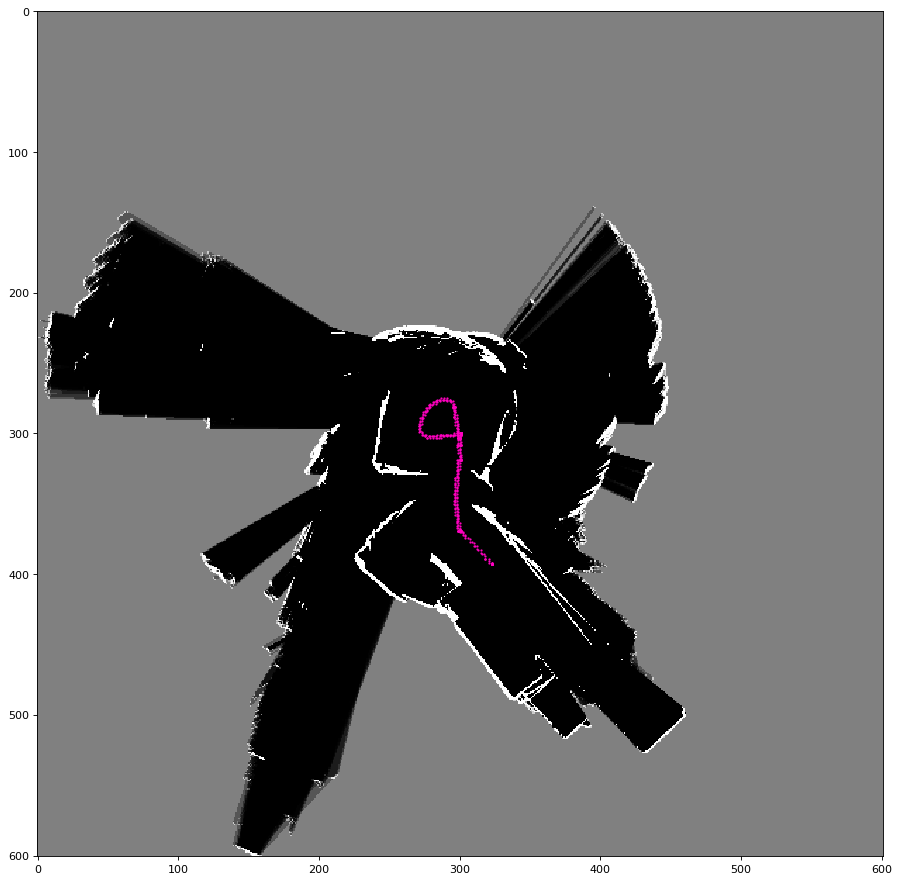

In [4]:
import pylab
from src.util import *

gamma = 1.0 - 1.0/(1.0 + np.exp(logodds.data))
print(gamma.max(), gamma.min())
print(logodds.data.shape)

state = np.array([0, 0, 0], dtype=np.float64)
posx = []
posy = []

for i, data in enumerate(datas):
    state[0] += data['lidar_delta_pose'][0, 0]
    state[1] += data['lidar_delta_pose'][0, 1]
    state[2] += data['lidar_delta_pose'][0, 2]
    
    x, y = logodds.coordinate_to_index([state[0], state[1]]).reshape(-1)
    if i % 20 == 0:
        posx.append(x)
        posy.append(y)

plot_map(gamma, [posx, posy], 20)

In [5]:
%load_ext autoreload
%autoreload 2
from src.slam import ParticleFilterSLAM

slam = ParticleFilterSLAM(
    n_particles=N_PARTICLES,
    n_efficient_threshold=N_EFF_THRESHOLD,
    map_xlim=MAP_XLIM,
    map_ylim=MAP_YLIM,
    map_resolution=MAP_RESOLUTION,
    map_logodds_lim=MAP_LOGODDS_LIM,
    map_logodds_occupied_diff=MAP_LOGODDS_OCCUPIED_DIFF,
    map_logodds_free_diff=MAP_LOGODDS_FREE_DIFF,
    map_logodds_occupied_threshold=MAP_LOGODDS_OCCUPIED_THRESHOLD,
    predict_noise_sigma=PREDICT_NOISE_SIGMA
)

states = [np.array([0, 0, 0])]
for i, data in enumerate(datas):
    with slam.set_robot_data(**data):
        u = slam.predict_particles(data['lidar_delta_pose'][0, :])
        corr, neff = slam.update_particles()

        states.append(slam.robot_state)

        if i % 1 == 0:
            print(i, slam.robot_state, neff, corr.max(), corr.min())
            slam.update_map_logodds()
        
        if i % 10 == 0:
            slam.update_map_texture()
            
                    
        if i % 50 == 0:
            if SAVE_MAP_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(1.0 - slam.map_prob, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
                
            if SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(slam.map_texture_trimmed, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
        plt.close('all')

0 [-0.06824655 -0.08767675 -0.01509228] 127.99999999999997 0.0 0.0
1 [-0.19440778 -0.12574849 -0.06114892] 127.99999999999997 0.0 0.0
2 [-0.1590316  -0.12367236 -0.05990133] 1.973514536574932 95.0 6.0
3 [-0.16621911 -0.12859799 -0.06440631] 1.036619639326455 296.0 66.0
4 [-0.17985239 -0.1271371  -0.06143313] 1.0993285682600915 518.0 145.0
5 [-0.17645221 -0.13249908 -0.06243489] 1.0000000002089564 626.0 147.0
6 [-0.17588056 -0.13283156 -0.0646489 ] 1.0002468196335366 619.0 140.0
7 [-0.17015984 -0.13313829 -0.05913331] 1.042601946561692 652.0 137.0
8 [-0.16902232 -0.14076283 -0.05874567] 1.0000379353417024 677.0 162.0
9 [-0.16744702 -0.12903059 -0.06001478] 1.267839315857283 674.0 166.0
10 [-0.17369582 -0.13998638 -0.05676774] 1.2808141842648146 646.0 192.0
11 [-0.1604596  -0.15312181 -0.05461199] 2.0000456932870723 688.0 170.0
12 [-0.15377392 -0.13937624 -0.06163335] 1.0052178385473964 695.0 158.0
13 [-0.16154578 -0.14694338 -0.0580382 ] 1.0000000015204478 700.0 155.0
14 [-0.15571757 -0

115 [-0.12555788 -0.16757991 -0.06372714] 1.0277217204274391 708.0 161.0
116 [-0.13072874 -0.17286578 -0.05587597] 1.2030990427310873 695.0 196.0
117 [-0.12433211 -0.17924428 -0.06098279] 1.0000045512051836 705.0 190.0
118 [-0.11357563 -0.15908397 -0.06666899] 1.004957474457689 696.0 157.0
119 [-0.12256026 -0.16813093 -0.06575196] 1.0000000043276032 711.0 168.0
120 [-0.12438064 -0.16731064 -0.06708432] 1.286372266123601 713.0 153.0
121 [-0.11784033 -0.17213332 -0.06761745] 1.0366193090658469 711.0 202.0
122 [-0.10697958 -0.16893721 -0.06539288] 1.1003074331061797 698.0 178.0
123 [-0.128006   -0.17399076 -0.06196191] 1.55766206934653 707.0 201.0
124 [-0.1159942  -0.16936701 -0.06502452] 1.5578519755388558 712.0 216.0
125 [-0.12528685 -0.16179576 -0.06549188] 1.0000002266249468 710.0 189.0
126 [-0.12714635 -0.17689987 -0.06402353] 1.000124208899825 709.0 177.0
127 [-0.11105543 -0.1738592  -0.06484432] 1.0007049518034463 708.0 190.0
128 [-0.11811658 -0.17583563 -0.06598912] 1.036620692163

229 [-0.11352383 -0.16900301 -0.06818486] 1.0137378455428174 714.0 159.0
230 [-0.12282061 -0.17185704 -0.06781644] 1.00365397050815 707.0 152.0
231 [-0.11736824 -0.16579066 -0.06627995] 1.120076078086625 714.0 172.0
232 [-0.12230514 -0.17851096 -0.06165278] 1.6503605818984821 703.0 178.0
233 [-0.12958708 -0.1727575  -0.06599938] 1.648366446003918 705.0 207.0
234 [-0.1264789  -0.16806331 -0.06676907] 1.0018238464056273 711.0 172.0
235 [-0.10353643 -0.17653996 -0.06966237] 1.0002166750607677 691.0 216.0
236 [-0.11469428 -0.17400444 -0.06212142] 1.0387788194147192 707.0 192.0
237 [-0.11275914 -0.1743454  -0.0596382 ] 1.6481784769025645 693.0 214.0
238 [-0.11412937 -0.17176719 -0.06341774] 2.0134532395648477 711.0 151.0
239 [-0.11263109 -0.17590513 -0.06309736] 1.0134769564122559 703.0 151.0
240 [-0.1179064  -0.1811743  -0.05857608] 2.626027706253531 693.0 154.0
241 [-0.11600907 -0.17838984 -0.05975655] 1.0000002607760263 697.0 237.0
242 [-0.10685207 -0.17457558 -0.06372273] 1.000012290780

342 [-0.11269632 -0.16821296 -0.06368561] 1.9651556455222285 710.0 158.0
343 [-0.10393777 -0.16955503 -0.07084037] 1.7725649578356868 701.0 151.0
344 [-0.10697508 -0.17019777 -0.07199433] 1.648055047727073 708.0 196.0
345 [-0.11907636 -0.16739911 -0.06880368] 1.1012512807551131 714.0 176.0
346 [-0.11482843 -0.17226263 -0.06814022] 1.004957730083922 708.0 164.0
347 [-0.10790731 -0.16772311 -0.06856396] 1.0134755964603772 709.0 189.0
348 [-0.12460831 -0.16810777 -0.06586138] 1.0134770406057696 709.0 187.0
349 [-0.11454122 -0.17514188 -0.06387054] 1.0522035213658487 705.0 215.0
350 [-0.12156942 -0.16480807 -0.06452538] 1.8772595061481565 709.0 195.0
351 [-0.12159906 -0.17083743 -0.0660702 ] 1.0000122900180748 710.0 205.0
352 [-0.10500955 -0.17228054 -0.06947604] 1.0000002292681667 707.0 181.0
353 [-0.1038555  -0.17168969 -0.06502338] 1.0006711503545496 708.0 213.0
354 [-0.10691247 -0.17696709 -0.06237984] 1.00207154796242 703.0 168.0
355 [-0.10723542 -0.17075745 -0.06447904] 1.00003341240

455 [-0.10396254 -0.16625631 -0.06247351] 1.0141513125853763 685.0 183.0
456 [-0.10190943 -0.16849535 -0.06843246] 1.000672589355085 709.0 188.0
457 [-0.11260679 -0.17248108 -0.06642715] 2.716082923675372 714.0 196.0
458 [-0.12198038 -0.17773292 -0.06462157] 1.0001033184988015 704.0 182.0
459 [-0.10999082 -0.17020427 -0.06394048] 1.766786432837788 708.0 215.0
460 [-0.11065781 -0.17490064 -0.06527842] 1.8957358528261665 711.0 180.0
461 [-0.1238362  -0.16718352 -0.06666655] 1.0052718844944488 710.0 183.0
462 [-0.10062717 -0.17132782 -0.06536052] 1.0366529978306978 706.0 172.0
463 [-0.112424   -0.17495575 -0.06684681] 1.2713277999660926 712.0 182.0
464 [-0.1133915  -0.17019772 -0.06418721] 1.2031123595275686 706.0 177.0
465 [-0.10807553 -0.16841985 -0.06751265] 1.0001047839911674 710.0 190.0
466 [-0.09714088 -0.16284716 -0.06804261] 1.0191429526148588 697.0 229.0
467 [-0.10258866 -0.17037804 -0.06730832] 1.0996213776838166 709.0 202.0
468 [-0.10601611 -0.17324157 -0.07268319] 1.0993629071

569 [-0.10176733 -0.15949215 -0.06808303] 1.2659037134532138 683.0 177.0
570 [-0.12367284 -0.17856252 -0.06553103] 1.6480562774463947 690.0 151.0
571 [-0.12320808 -0.16358199 -0.06820267] 1.0366529972909273 696.0 179.0
572 [-0.10200011 -0.16520014 -0.06659783] 2.6661071099697096 704.0 203.0
573 [-0.11650166 -0.17125847 -0.06554303] 1.3759039044163668 714.0 172.0
574 [-0.116943   -0.17010684 -0.06924322] 1.648054273669078 705.0 205.0
575 [-0.09983847 -0.17716147 -0.06378813] 1.2658022293872995 699.0 218.0
576 [-0.11009381 -0.17084603 -0.06706353] 1.0184675297758523 712.0 178.0
577 [-0.12800108 -0.17251335 -0.06619141] 2.2598847578462604 700.0 256.0
578 [-0.11981288 -0.17324493 -0.06177405] 1.0006717705835444 694.0 197.0
579 [-0.11673107 -0.17782642 -0.0657619 ] 1.1186720694661012 705.0 219.0
580 [-0.10207566 -0.17125809 -0.06664648] 1.0000129002345388 709.0 185.0
581 [-0.10491084 -0.17268175 -0.06519538] 1.0366196782904968 710.0 219.0
582 [-0.10964516 -0.1746696  -0.06783597] 1.03662528

682 [-0.11190316 -0.1684369  -0.06838145] 1.993817498693842 714.0 193.0
683 [-0.10320102 -0.17411588 -0.06839229] 1.0049620059641566 706.0 241.0
684 [-0.11587239 -0.17392612 -0.06356825] 1.0000379354572124 711.0 204.0
685 [-0.12081064 -0.1757667  -0.06604253] 1.099327950888172 708.0 180.0
686 [-0.12683947 -0.1666241  -0.0663925 ] 1.0000009501478666 701.0 227.0
687 [-0.1018689  -0.16897645 -0.06559787] 1.648351912233744 707.0 210.0
688 [-0.09953723 -0.16922832 -0.07032495] 2.4282587987914663 712.0 174.0
689 [-0.10851944 -0.16969903 -0.06469839] 1.0000016630690518 710.0 194.0
690 [-0.11988425 -0.16954923 -0.06782484] 1.000280236490775 710.0 226.0
691 [-0.10790997 -0.16581478 -0.06608914] 1.0366206908298727 708.0 180.0
692 [-0.11075903 -0.17404257 -0.06603949] 1.1376780583554011 712.0 220.0
693 [-0.10657799 -0.16893328 -0.06955579] 1.6667703863428727 711.0 224.0
694 [-0.09760723 -0.17017249 -0.07200174] 1.6480548212183197 707.0 246.0
695 [-0.100572   -0.1702891  -0.07015983] 1.00499262708

795 [-0.09639907 -0.16741975 -0.07012526] 1.0003377749697184 706.0 213.0
796 [-0.10689007 -0.17225817 -0.07127678] 1.6643042360929723 707.0 188.0
797 [-0.11507324 -0.16732183 -0.06774961] 1.2658161803233603 711.0 201.0
798 [-0.11652341 -0.17135809 -0.0688039 ] 1.101337814590614 705.0 242.0
799 [-0.11222943 -0.16917783 -0.06880145] 1.648069182458915 711.0 216.0
800 [-0.11637742 -0.17208316 -0.06953892] 1.137680717494407 706.0 241.0
801 [-0.10736116 -0.17011382 -0.0689193 ] 1.013475902487101 712.0 195.0
802 [-0.10541618 -0.16933557 -0.06713659] 1.698031393602545 714.0 174.0
803 [-0.09523433 -0.17200985 -0.06876271] 1.6710908733350376 709.0 183.0
804 [-0.12628566 -0.17300431 -0.06436186] 1.0137328579542755 701.0 206.0
805 [-0.09325587 -0.17190042 -0.06986483] 1.0137237954228158 707.0 202.0
806 [-0.10725485 -0.17312463 -0.06750823] 1.0209885774474283 711.0 231.0
807 [-0.11109144 -0.16904971 -0.0684975 ] 1.0027436515087575 713.0 222.0
808 [-0.10377932 -0.17067814 -0.0668747 ] 2.004954417027

909 [-0.11078671 -0.17327493 -0.06402007] 1.0006758011315926 705.0 190.0
910 [-0.10279969 -0.16980467 -0.07267953] 2.3719946140709336 708.0 265.0
911 [-0.09701398 -0.16922638 -0.06963993] 1.0 709.0 281.0
912 [-0.1061528  -0.16794531 -0.06954846] 1.1045187793383242 708.0 238.0
913 [-0.10487505 -0.16950738 -0.06851632] 1.037394447734646 713.0 247.0
914 [-0.11371636 -0.17083567 -0.07038249] 1.1000370832287345 709.0 227.0
915 [-0.11168923 -0.16883522 -0.06698659] 1.0000334034293177 708.0 203.0
916 [-0.10732341 -0.16799684 -0.06946787] 1.2050998374649906 710.0 219.0
917 [-0.11120246 -0.17273168 -0.06819465] 2.3714327796037193 710.0 210.0
918 [-0.10604154 -0.16766232 -0.06735195] 1.0019269453767248 710.0 193.0
919 [-0.10906673 -0.17006258 -0.06540203] 1.0049581192664763 705.0 175.0
920 [-0.10938733 -0.17210016 -0.06078334] 1.4242458411783485 689.0 200.0
921 [-0.11093975 -0.16512469 -0.06743404] 1.0000001173825743 710.0 198.0
922 [-0.10911673 -0.16785935 -0.07107096] 1.2669267588035609 709.0 

1023 [-0.10179987 -0.16655831 -0.06994788] 1.030249615896447 711.0 233.0
1024 [-0.11836282 -0.17528173 -0.06444116] 1.6920949033652044 708.0 195.0
1025 [-0.10160612 -0.17026621 -0.06684476] 1.0000007058844578 708.0 198.0
1026 [-0.09665557 -0.16683925 -0.06951697] 1.6926983017210906 704.0 219.0
1027 [-0.11899603 -0.17367183 -0.06740263] 1.0018316163497853 709.0 233.0
1028 [-0.10370551 -0.17415331 -0.06581942] 1.2658141687939286 708.0 209.0
1029 [-0.11387609 -0.17371347 -0.06781859] 2.2651014863909906 708.0 218.0
1030 [-0.09637985 -0.16856746 -0.07427789] 1.0057334365027735 707.0 208.0
1031 [-0.10986767 -0.17110287 -0.0651429 ] 1.0049577302614674 705.0 179.0
1032 [-0.1214598  -0.17240146 -0.06814396] 1.0007043704337277 707.0 185.0
1033 [-0.11021609 -0.16590217 -0.07166078] 1.769458637760082 706.0 210.0
1034 [-0.10186799 -0.16720067 -0.0671696 ] 2.013452889092681 709.0 204.0
1035 [-0.11169404 -0.17320199 -0.06693235] 1.2665503287830482 711.0 216.0
1036 [-0.11245648 -0.16778851 -0.06900253

1133 [-0.10644846 -0.1711392  -0.07383426] 2.0371395262145997 694.0 215.0
1134 [-0.0936653  -0.16871884 -0.07502817] 1.0000023053235583 706.0 221.0
1135 [-0.11002906 -0.17063032 -0.06780069] 1.0052959408051318 713.0 226.0
1136 [-0.11809256 -0.17277759 -0.07084014] 1.113530354011157 700.0 216.0
1137 [-0.10393108 -0.17126593 -0.0706294 ] 1.1012726849113714 711.0 229.0
1138 [-0.11814526 -0.16985848 -0.06713201] 2.1224177949033507 709.0 235.0
1139 [-0.11306999 -0.17440661 -0.06657047] 1.0020966478233773 710.0 209.0
1140 [-0.09687026 -0.16931193 -0.071406  ] 2.0000910239044725 709.0 198.0
Updating map texture......
1141 [-0.12161964 -0.17084732 -0.06574508] 1.1520856012089118 701.0 234.0
1142 [-0.09349804 -0.1660797  -0.07342521] 1.0036491849265692 706.0 185.0
1143 [-0.0941202  -0.17126147 -0.07231233] 1.0134752828117257 706.0 206.0
1144 [-0.10349792 -0.1674068  -0.06873626] 1.005308275525822 713.0 192.0
1145 [-0.09708503 -0.17287163 -0.06622709] 1.0049576399010156 698.0 193.0
1146 [-0.1029

Updating map texture......
1241 [-0.11395273 -0.16783128 -0.06470105] 1.0049909598906779 698.0 258.0
1242 [-0.0959144  -0.17326078 -0.07046041] 1.708460678494131 701.0 210.0
1243 [-0.10543392 -0.1646118  -0.07026913] 1.6489176624713597 705.0 204.0
1244 [-0.12506882 -0.16677501 -0.06591575] 1.0797175857695427 700.0 222.0
1245 [-0.08929703 -0.17128869 -0.07514059] 1.0018360661608374 693.0 194.0
1246 [-0.10929141 -0.17287174 -0.06813698] 1.0049646060912645 707.0 218.0
1247 [-0.10676431 -0.17957034 -0.06232143] 1.3915392252932919 687.0 206.0
1248 [-0.12046554 -0.17294638 -0.06797167] 1.0000002250781235 709.0 192.0
1249 [-0.0980415  -0.16899175 -0.07200092] 1.2678397458018695 706.0 189.0
1250 [-0.10139791 -0.16839995 -0.07367759] 1.0373950606922642 704.0 205.0
Updating map texture......
1251 [-0.11005975 -0.17937907 -0.06368592] 1.1107829769670532 689.0 208.0
1252 [-0.10477519 -0.17031558 -0.06970542] 1.0134752839546963 712.0 180.0
1253 [-0.1111358  -0.17073355 -0.06888276] 1.00012450295302

1350 [-0.11108564 -0.17509288 -0.06719164] 1.0006709293043896 677.0 213.0
Updating map texture......
1351 [-0.12493816 -0.17582334 -0.06702548] 1.139584211235699 679.0 208.0
1352 [-0.12076656 -0.1662805  -0.06790379] 1.000709170040329 677.0 207.0
1353 [-0.11246326 -0.16224147 -0.07010328] 1.004958121908405 677.0 196.0
1354 [-0.11890517 -0.17319915 -0.06789116] 1.0000385406323402 683.0 203.0
1355 [-0.10528052 -0.17104499 -0.06683118] 1.000006183952924 685.0 195.0
1356 [-0.10690216 -0.16641773 -0.06974758] 1.0184658499608827 686.0 209.0
1357 [-0.11617956 -0.16913738 -0.06819996] 1.03666550676673 687.0 205.0
1358 [-0.11103982 -0.16688962 -0.0692611 ] 1.0375579250218254 684.0 199.0
1359 [-0.11240891 -0.16163527 -0.06793886] 1.2658209714734208 672.0 181.0
1360 [-0.12424376 -0.17281401 -0.06681602] 1.3066551100592458 684.0 199.0
Updating map texture......
1361 [-0.1075945  -0.16821838 -0.06086671] 1.3778159729009645 650.0 224.0
1362 [-0.11269864 -0.17341376 -0.07030113] 1.0049591716027446 67

1458 [-0.1135564  -0.17490813 -0.06495749] 1.0000016783892882 687.0 225.0
1459 [-0.09836266 -0.17007996 -0.06826873] 1.3783484650695919 683.0 205.0
1460 [-0.12382024 -0.16862127 -0.06827682] 1.0000006286774026 676.0 202.0
Updating map texture......
1461 [-0.11401718 -0.17265029 -0.06487907] 1.6481151205252025 687.0 236.0
1462 [-0.10237751 -0.1793357  -0.06279904] 1.6540291198023178 661.0 193.0
1463 [-0.1116975  -0.17221167 -0.06795651] 1.039205710191496 678.0 203.0
1464 [-0.11715693 -0.16301639 -0.06904926] 3.037176624721319 672.0 201.0
1465 [-0.09857991 -0.17288071 -0.07141433] 1.036884458611428 682.0 206.0
1466 [-0.11577139 -0.17141314 -0.06940176] 1.013475940075184 687.0 190.0
1467 [-0.10989757 -0.168669   -0.06598547] 1.2659048266874555 677.0 216.0
1468 [-0.11471115 -0.17260559 -0.06571256] 1.000000255532106 679.0 196.0
1469 [-0.1001659  -0.16533887 -0.07468058] 1.0019269771785706 664.0 221.0
1470 [-0.11589895 -0.16866383 -0.07018824] 1.0000002252793494 679.0 194.0
Updating map tex

1567 [-0.10772712 -0.16998911 -0.07067885] 1.0049697970406526 696.0 198.0
1568 [-0.10799689 -0.17684335 -0.06290424] 1.1376809786416129 683.0 210.0
1569 [-0.10400301 -0.17045169 -0.06803328] 1.0366189935268546 696.0 197.0
1570 [-0.11017471 -0.17201709 -0.06700245] 1.766352801483566 694.0 199.0
Updating map texture......
1571 [-0.10889725 -0.17323716 -0.06473179] 1.041678149252147 693.0 217.0
1572 [-0.1032129  -0.16620422 -0.07131799] 1.0000000000002274 709.0 208.0
1573 [-0.10186479 -0.17140198 -0.06750759] 1.5576599890629719 704.0 209.0
1574 [-0.10505607 -0.16763235 -0.07125398] 1.0002468355238292 701.0 212.0
1575 [-0.10907059 -0.17095209 -0.06645859] 1.0000123712276292 697.0 207.0
1576 [-0.12496699 -0.17334967 -0.06449656] 1.0004627784734637 679.0 221.0
1577 [-0.10122682 -0.1689029  -0.07172046] 1.2031354623504185 700.0 207.0
1578 [-0.0972281 -0.172963  -0.0717447] 1.0436208876140316 693.0 189.0
1579 [-0.1100905  -0.16266615 -0.06951578] 2.000033722415651 701.0 212.0
1580 [-0.10148268

1675 [-0.10431626 -0.17811615 -0.06660654] 1.6562265747856881 704.0 210.0
1676 [-0.11840879 -0.17851955 -0.06508357] 1.0007150633959097 705.0 215.0
1677 [-0.10367436 -0.16668491 -0.07030003] 2.0002474240490162 720.0 197.0
1678 [-0.09242952 -0.16628896 -0.07482236] 1.0049593400465726 709.0 222.0
1679 [-0.09168936 -0.17355542 -0.07013463] 1.0024955296377942 709.0 212.0
1680 [-0.10576613 -0.17332548 -0.06855947] 1.2828593812412525 718.0 221.0
Updating map texture......
1681 [-0.12017722 -0.17505362 -0.06389241] 1.2105216750693566 714.0 240.0
1682 [-0.09942197 -0.16458951 -0.06881202] 1.1007685415620476 715.0 215.0
1683 [-0.10051746 -0.16816736 -0.07022621] 1.2658303123615833 717.0 219.0
1684 [-0.10722834 -0.16279508 -0.07016293] 2.0018233474146094 714.0 218.0
1685 [-0.08894738 -0.16982801 -0.07266006] 1.1376418293134738 710.0 188.0
1686 [-0.11008741 -0.17521419 -0.06643998] 2.0000000001034626 714.0 197.0
1687 [-0.10144091 -0.16463334 -0.06573276] 2.362813472152017 698.0 214.0
1688 [-0.095

1783 [-0.10649525 -0.17231372 -0.06983876] 1.125991321489048 656.0 207.0
1784 [-0.12151861 -0.17069806 -0.06935001] 1.0023197814880644 653.0 200.0
1785 [-0.10762925 -0.1675437  -0.06996091] 1.2810324132156912 659.0 195.0
1786 [-0.09297484 -0.16802682 -0.0745596 ] 1.6562244922105591 658.0 165.0
1787 [-0.11449203 -0.16010139 -0.06982601] 1.0271255960524461 654.0 210.0
1788 [-0.11445896 -0.16787186 -0.0667767 ] 1.0413072458166768 653.0 214.0
1789 [-0.11304988 -0.17159596 -0.06905837] 2.099153071442902 655.0 194.0
1790 [-0.11058677 -0.17159822 -0.07089637] 1.0000023591976013 660.0 220.0
Updating map texture......
1791 [-0.09988314 -0.17033916 -0.07081984] 1.0000351896144675 661.0 195.0
1792 [-0.10862019 -0.17352391 -0.07026522] 1.282861277387071 661.0 215.0
1793 [-0.11468024 -0.17265056 -0.06879746] 1.013513547683906 664.0 220.0
1794 [-0.09150322 -0.15841399 -0.07207665] 1.6513984357007858 661.0 170.0
1795 [-0.12189112 -0.16944954 -0.06404329] 1.7679179579708393 638.0 228.0
1796 [-0.107753

1891 [-0.08334546 -0.18753158 -0.13293561] 1.0367160404625466 690.0 212.0
1892 [-0.10232062 -0.17774082 -0.12553524] 1.9893243988700695 690.0 199.0
1893 [-0.09502626 -0.17984629 -0.1275092 ] 1.0049939178922545 690.0 198.0
1894 [-0.07288141 -0.1747694  -0.12300018] 1.036619078390359 682.0 224.0
1895 [-0.08738269 -0.17377185 -0.11742881] 2.006589127044493 683.0 239.0
1896 [-0.08360169 -0.16850537 -0.1223961 ] 1.0385096556726616 685.0 250.0
1897 [-0.09667161 -0.16910356 -0.11764815] 2.275528816287246 679.0 225.0
1898 [-0.08192965 -0.15613803 -0.12538035] 1.649053232148463 679.0 180.0
1899 [-0.08511451 -0.15682878 -0.12165268] 1.0369091727984145 687.0 212.0
1900 [-0.08301527 -0.15798765 -0.11513025] 1.2659407756655088 684.0 199.0
Updating map texture......
1901 [-0.09004666 -0.14624924 -0.11473227] 1.015420282861196 681.0 167.0
1902 [-0.08347012 -0.15545456 -0.1094886 ] 1.1429309537817591 679.0 201.0
1903 [-0.07480891 -0.15255267 -0.10824968] 1.284016726686495 678.0 200.0
1904 [-0.09200998

1999 [-0.06401749 -0.19876391 -0.12697077] 1.020322104069303 696.0 218.0
2000 [-0.05784819 -0.19837292 -0.13082609] 1.00185886518168 688.0 234.0
Updating map texture......
2001 [-0.06403263 -0.20160753 -0.12172643] 1.6543225743301226 693.0 219.0
2002 [-0.06504175 -0.19932691 -0.1207191 ] 1.0018377281922581 683.0 233.0
2003 [-0.08337859 -0.1894833  -0.11827667] 1.0000006123626493 693.0 219.0
2004 [-0.08787337 -0.19120747 -0.11035871] 1.0368702660497318 671.0 212.0
2005 [-0.08337174 -0.18611833 -0.10950075] 1.036619509622472 672.0 274.0
2006 [-0.06686526 -0.1658087  -0.11837184] 1.2808148830016284 674.0 218.0
2007 [-0.06479612 -0.16494348 -0.12435362] 1.308761955159382 652.0 228.0
2008 [-0.07768788 -0.15232923 -0.12619446] 1.0001371062520366 667.0 232.0
2009 [-0.08647614 -0.16449385 -0.1300516 ] 1.004325945535139 665.0 146.0
2010 [-0.08021827 -0.15869102 -0.13973136] 1.0001410155700692 669.0 203.0
Updating map texture......
2011 [-0.09375329 -0.16793419 -0.13924078] 1.0000379241676813 68

2107 [-0.10424495 -0.16635974 -0.12653457] 1.0000000041234216 693.0 184.0
2108 [-0.09309697 -0.17123362 -0.11994127] 1.6481647203442664 686.0 232.0
2109 [-0.09812746 -0.17572727 -0.11532471] 1.0000924783215224 693.0 229.0
2110 [-0.09635756 -0.17333672 -0.11453178] 1.0000000833565554 689.0 184.0
Updating map texture......
2111 [-0.09645069 -0.17374124 -0.10310424] 1.0134758981221494 684.0 202.0
2112 [-0.08954522 -0.17010902 -0.11142501] 1.0000908867868186 676.0 226.0
2113 [-0.09107808 -0.1680368  -0.10524859] 1.0366189950174205 684.0 155.0
2114 [-0.09884391 -0.18459454 -0.1028848 ] 1.5801471955202653 673.0 231.0
2115 [-0.0846879  -0.17046013 -0.10973918] 1.0370020424119726 688.0 231.0
2116 [-0.09145343 -0.17758842 -0.11255385] 1.0009178293762664 683.0 233.0
2117 [-0.06508728 -0.18394498 -0.1203773 ] 1.0003425209413483 689.0 241.0
2118 [-0.06308216 -0.1929694  -0.11234351] 2.640759760309814 686.0 155.0
2119 [-0.05076093 -0.17515647 -0.12576161] 1.4775205739862094 686.0 170.0
2120 [-0.059

2215 [-0.08777283 -0.17489556 -0.04833714] 1.0068813869841573 693.0 221.0
2216 [-0.07565138 -0.16928043 -0.04673674] 1.0000022748629196 685.0 207.0
2217 [-0.07597582 -0.1556148  -0.05248496] 1.004957475425619 686.0 207.0
2218 [-0.08218295 -0.15372073 -0.05201274] 1.0373065803607504 675.0 211.0
2219 [-0.06588941 -0.14830591 -0.0553346 ] 1.2844613941719751 676.0 195.0
2220 [-0.05481507 -0.14169456 -0.06313707] 1.2719064870563868 674.0 192.0
Updating map texture......
2221 [-0.05004335 -0.13978522 -0.06498558] 1.0015900733832912 669.0 187.0
2222 [-0.06614964 -0.14592952 -0.05472767] 1.0135684366696491 674.0 206.0
2223 [-0.06903251 -0.13942012 -0.04803297] 1.9615148281156993 671.0 178.0
2224 [-0.05492938 -0.14168289 -0.04836538] 1.0106395419897647 674.0 172.0
2225 [-0.04057891 -0.13366231 -0.04234215] 1.9353500169579456 652.0 173.0
2226 [-0.05605853 -0.13673004 -0.04004025] 1.3124633871102138 661.0 157.0
2227 [-0.04508899 -0.14487257 -0.03118963] 1.000705291796796 667.0 150.0
2228 [-0.0712

2323 [ 0.07477818 -0.2055677  -0.03271722] 2.6273744002645976 732.0 217.0
2324 [ 0.09065359 -0.19605352 -0.03674496] 1.0000006120118115 721.0 191.0
2325 [ 0.10172987 -0.20012373 -0.04533107] 1.0038697295241854 729.0 198.0
2326 [ 0.11166473 -0.19613687 -0.04659158] 2.050035205250309 721.0 232.0
2327 [ 0.08614773 -0.18599731 -0.04621058] 2.005626763977792 726.0 229.0
2328 [ 0.09773213 -0.18590006 -0.03441042] 1.7040902381175003 694.0 224.0
2329 [ 0.09394813 -0.17862977 -0.03472107] 1.0000351895417052 710.0 182.0
2330 [ 0.0807247  -0.17711638 -0.02852991] 1.036631587216911 696.0 193.0
Updating map texture......
2331 [ 0.10459394 -0.16656633 -0.03623058] 2.0864916528012722 697.0 198.0
2332 [ 0.08771065 -0.17171009 -0.03013566] 1.006304564936375 695.0 207.0
2333 [ 0.07126917 -0.16509219 -0.03026464] 2.3004396014586455 694.0 207.0
2334 [ 0.07987261 -0.16595427 -0.03246448] 1.6555544610585267 682.0 200.0
2335 [ 0.07794666 -0.16675981 -0.0311698 ] 3.5874291326027277 693.0 212.0
2336 [ 0.086047

2431 [ 0.24182243 -0.1556972  -0.010921  ] 1.0740413633114865 713.0 191.0
2432 [ 0.2311958  -0.16112203  0.00040087] 1.5684330788138336 719.0 199.0
2433 [ 0.23253389 -0.15706506 -0.00936304] 1.005567447348461 715.0 172.0
2434 [ 0.22428237 -0.15408464 -0.00622765] 1.021124111689621 705.0 180.0
2435 [ 0.22829288 -0.15507752 -0.00762897] 1.0746390241505452 711.0 206.0
2436 [ 0.22950757 -0.16399431 -0.0113118 ] 1.9441836758809277 712.0 203.0
2437 [ 0.23799153 -0.16197988 -0.02336332] 2.829725350773355 713.0 186.0
2438 [ 0.23597025 -0.16429177 -0.02780945] 1.0292838213320328 721.0 169.0
2439 [ 0.23961213 -0.17860156 -0.03059673] 1.6642710369618254 719.0 203.0
2440 [ 0.24047121 -0.18019093 -0.03665642] 1.1047094508295983 715.0 170.0
Updating map texture......
2441 [ 0.23783661 -0.18584549 -0.03930796] 1.1787710050028675 725.0 171.0
2442 [ 0.25893355 -0.19008773 -0.04475185] 1.0020832051308346 733.0 192.0
2443 [ 0.2571269  -0.18897633 -0.0412407 ] 1.664279787500707 713.0 189.0
2444 [ 0.280766

2539 [ 0.40112034 -0.15163162  0.05091874] 1.0823949478806685 681.0 154.0
2540 [ 0.41290295 -0.13357643  0.0459145 ] 2.970219943396477 677.0 177.0
Updating map texture......
2541 [ 0.41612461 -0.13577031  0.04298527] 2.052664560426504 680.0 200.0
2542 [ 0.41542678 -0.1137226   0.03727651] 1.8026028003310448 676.0 167.0
2543 [ 0.41875903 -0.1168778   0.03549364] 2.421594712785031 680.0 180.0
2544 [ 0.42765418 -0.12642135  0.02992439] 1.243844608444263 682.0 173.0
2545 [ 0.4247348  -0.12984188  0.02952572] 1.6509584267828263 674.0 191.0
2546 [ 0.42946986 -0.11804659  0.03342966] 3.6860965097556533 671.0 190.0
2547 [ 0.42502932 -0.12636114  0.04107318] 3.0068355029532445 672.0 158.0
2548 [ 0.42113925 -0.12991866  0.04986203] 1.2041403726203035 670.0 139.0
2549 [ 0.42911202 -0.123892    0.0552232 ] 1.699475919903034 677.0 160.0
2550 [ 0.42052496 -0.11899331  0.06178827] 1.1520379002725347 674.0 208.0
Updating map texture......
2551 [ 0.42203254 -0.12128079  0.0606912 ] 1.2727632479626678 6

2647 [ 0.56594798 -0.14308922  0.07688534] 1.959938387620796 696.0 134.0
2648 [ 0.56820161 -0.162571    0.07726021] 1.187346987006597 674.0 168.0
2649 [ 0.56937755 -0.14605645  0.07864393] 1.0366235953871952 684.0 192.0
2650 [ 0.56205728 -0.12727932  0.08707657] 1.7831095780969386 671.0 165.0
Updating map texture......
2651 [ 0.56143423 -0.13079979  0.08908433] 1.0134753128852152 672.0 159.0
2652 [ 0.56155598 -0.12231667  0.09355644] 1.0000334034015772 625.0 187.0
2653 [ 0.57112816 -0.12303501  0.08906713] 1.0141860088786299 676.0 141.0
2654 [ 0.56461811 -0.12017585  0.08587677] 1.0134877475171662 686.0 134.0
2655 [ 0.5620726  -0.14146619  0.08771671] 1.013513460918575 666.0 154.0
2656 [ 0.55619362 -0.12565996  0.08675853] 1.1396374486745586 684.0 155.0
2657 [ 0.55745258 -0.13304529  0.08861861] 1.0086168983963877 678.0 141.0
2658 [ 0.55661945 -0.1325621   0.08773684] 1.0660401515238074 664.0 139.0
2659 [ 0.563205   -0.12303637  0.08265993] 1.013480286363714 682.0 175.0
2660 [ 0.551137

2755 [ 0.67303266 -0.13394392  0.04364361] 1.2808330482029646 694.0 151.0
2756 [ 0.66827629 -0.1342938   0.05004755] 2.1051254498062817 729.0 192.0
2757 [ 0.67030208 -0.14022402  0.04516822] 2.1138545691553414 728.0 169.0
2758 [ 0.68586727 -0.14312211  0.04740337] 1.307341137897099 719.0 193.0
2759 [ 0.6775529  -0.12962579  0.04812437] 1.3780217149173197 725.0 186.0
2760 [ 0.67697525 -0.13912848  0.05408786] 1.0106060754252575 697.0 188.0
Updating map texture......
2761 [ 0.67814212 -0.13651162  0.05735152] 2.3386330272479388 694.0 204.0
2762 [ 0.68664933 -0.12695323  0.05618152] 2.3712261943190427 695.0 210.0
2763 [ 0.68217706 -0.12145695  0.06327571] 1.3762292361795103 695.0 191.0
2764 [ 0.69936797 -0.12192759  0.05775787] 1.0270418296761679 691.0 223.0
2765 [ 0.69544984 -0.10093972  0.06206277] 1.0056300937167815 694.0 173.0
2766 [ 0.68126448 -0.08482337  0.06332228] 1.00495765116314 663.0 179.0
2767 [ 0.6994724  -0.10792579  0.0625826 ] 1.036695647722812 720.0 161.0
2768 [ 0.705277

2863 [ 0.83790355 -0.14417811  0.07563433] 1.650565276187798 739.0 214.0
2864 [ 0.82915973 -0.13072039  0.08796701] 1.692285332283401 721.0 188.0
2865 [ 0.85061419 -0.14824308  0.09433584] 1.000034240599195 737.0 226.0
2866 [ 0.86490119 -0.14900723  0.09527789] 1.0141509591012605 721.0 208.0
2867 [ 0.86355586 -0.14878589  0.0952315 ] 1.0057556163857717 747.0 199.0
2868 [ 0.8686517  -0.1598589   0.09599908] 2.0000023596743848 735.0 219.0
2869 [ 0.86379869 -0.1498341   0.08572867] 1.6480542736642068 757.0 197.0
2870 [ 0.85607482 -0.12329934  0.08707921] 1.9590203277091107 751.0 196.0
Updating map texture......
2871 [ 0.87940995 -0.133747    0.08381024] 1.2678516141616518 737.0 218.0
2872 [ 0.87354757 -0.14171057  0.0839277 ] 2.0006708704694542 728.0 209.0
2873 [ 0.86317339 -0.13253583  0.08064065] 1.2658534224038154 741.0 194.0
2874 [ 0.86143204 -0.13905507  0.08055535] 1.005387204659404 760.0 213.0
2875 [ 0.86397018 -0.10538025  0.08408736] 1.2808141970614633 753.0 228.0
2876 [ 0.842653

2971 [ 0.99876162 -0.07757931  0.09398727] 1.0000022748920236 759.0 224.0
2972 [ 0.99322209 -0.08320506  0.09194325] 1.0000000829300024 786.0 247.0
2973 [ 0.99923851 -0.10675957  0.08545698] 1.0384904287117094 755.0 196.0
2974 [ 0.99278802 -0.12151748  0.07504265] 1.0000045207738077 786.0 208.0
2975 [ 0.98229774 -0.09567826  0.07312171] 1.6980798045793624 792.0 200.0
2976 [ 0.98529054 -0.08903361  0.07257455] 2.041810010520397 790.0 238.0
2977 [ 0.986415   -0.08443739  0.07064329] 1.0050491116031697 797.0 158.0
2978 [ 0.9775725  -0.08689064  0.07047792] 1.0000379548017617 804.0 209.0
2979 [ 0.97911435 -0.10387478  0.07027971] 2.669191670524568 799.0 230.0
2980 [ 0.97344044 -0.12550657  0.07230818] 1.0994295198422188 786.0 225.0
Updating map texture......
2981 [ 0.97876908 -0.12689219  0.0662144 ] 1.796007284563208 790.0 196.0
2982 [ 0.9901734  -0.11368409  0.06687906] 1.0366190778970392 780.0 205.0
2983 [ 0.97499517 -0.12504516  0.06713641] 1.0384853414915418 784.0 203.0
2984 [ 0.97991

3079 [ 1.12931022 -0.13515701 -0.21169408] 1.0002474388460503 868.0 224.0
3080 [ 1.13926494 -0.12386844 -0.21318964] 1.3915520801649568 849.0 238.0
Updating map texture......
3081 [ 1.13005509 -0.11511055 -0.2183095 ] 1.4341577051030332 848.0 242.0
3082 [ 1.13313068 -0.12154426 -0.21341151] 1.2658024893592712 862.0 192.0
3083 [ 1.13817894 -0.08521756 -0.21445449] 1.000033424424113 877.0 195.0
3084 [ 1.14049474 -0.11956798 -0.21651552] 1.7663506428935445 874.0 234.0
3085 [ 1.1573255  -0.12472624 -0.21956109] 1.0000351844278914 877.0 238.0
3086 [ 1.15360936 -0.08530031 -0.22467526] 1.099622017867045 881.0 227.0
3087 [ 1.17558649 -0.10001569 -0.22733614] 1.648863307158212 873.0 184.0
3088 [ 1.17799447 -0.09156169 -0.23240164] 1.648689399076557 866.0 226.0
3089 [ 1.18955426 -0.10286113 -0.24110376] 1.0373144964599255 870.0 250.0
3090 [ 1.19486112 -0.07889375 -0.24626468] 1.0366316032298477 830.0 259.0
Updating map texture......
3091 [ 1.19341653 -0.10349467 -0.2527835 ] 2.3737092027818334 

3187 [ 1.27140512 -0.21900516 -0.59599351] 1.0006787746989365 957.0 218.0
3188 [ 1.26852489 -0.21483436 -0.60428586] 1.0136614499937415 922.0 233.0
3189 [ 1.26937869 -0.2161738  -0.59971821] 1.0000170652017086 957.0 227.0
3190 [ 1.27703642 -0.23780158 -0.60924687] 1.0000000833667873 946.0 244.0
Updating map texture......
3191 [ 1.28087026 -0.21704136 -0.62093084] 1.0000016671804295 941.0 208.0
3192 [ 1.28234422 -0.21206119 -0.62930951] 1.2720079648436322 945.0 234.0
3193 [ 1.27724813 -0.20269781 -0.64119769] 1.8885229941385857 945.0 251.0
3194 [ 1.2797274  -0.22995134 -0.64901798] 1.0006709251841173 973.0 212.0
3195 [ 1.28371269 -0.24230738 -0.65796479] 1.0067859704828774 967.0 269.0
3196 [ 1.28639773 -0.20631549 -0.66102809] 1.6562413241174936 977.0 227.0
3197 [ 1.28957377 -0.2191666  -0.66379729] 1.0018243747772 971.0 260.0
3198 [ 1.2834977  -0.2175455  -0.66401773] 1.0000145786293348 968.0 245.0
3199 [ 1.28084201 -0.21535452 -0.66025635] 1.0740172616545438 956.0 267.0
3200 [ 1.28074

3295 [ 1.40552773 -0.30835921 -1.04505165] 1.3065478170725244 957.0 291.0
3296 [ 1.40200312 -0.29019224 -1.05420341] 1.0879477302931078 954.0 267.0
3297 [ 1.39512759 -0.31309196 -1.05620687] 1.0000014486803903 944.0 300.0
3298 [ 1.38831749 -0.30502915 -1.05996969] 1.0000005345358451 937.0 268.0
3299 [ 1.38856076 -0.31030839 -1.06527908] 1.3759041657505706 960.0 343.0
3300 [ 1.39035393 -0.2852393  -1.06298876] 3.1348107307122666 959.0 309.0
Updating map texture......
3301 [ 1.38658193 -0.32483338 -1.05782191] 1.013487658560251 971.0 282.0
3302 [ 1.37633218 -0.30162948 -1.05284103] 2.2733699263086824 961.0 285.0
3303 [ 1.37712354 -0.3015168  -1.05069067] 2.0000176671263143 956.0 315.0
3304 [ 1.38038265 -0.27937466 -1.05991413] 1.0000006906161347 952.0 294.0
3305 [ 1.39076639 -0.30089953 -1.05913628] 2.087344745143843 948.0 250.0
3306 [ 1.37735663 -0.30134126 -1.05983816] 1.0000000307045414 967.0 293.0
3307 [ 1.38631647 -0.30667031 -1.07097613] 1.2810909975956832 966.0 303.0
3308 [ 1.3939

3403 [ 1.44941559 -0.44176384 -1.38788114] 1.0000016677581869 936.0 284.0
3404 [ 1.44596704 -0.43356384 -1.38189679] 2.0000381684893616 952.0 308.0
3405 [ 1.43324624 -0.43480314 -1.37889465] 1.0832538887143874 954.0 276.0
3406 [ 1.4459892  -0.44601605 -1.37708973] 1.265822827962069 964.0 278.0
3407 [ 1.44746267 -0.46586636 -1.37969943] 1.3760766793645087 956.0 250.0
3408 [ 1.44294915 -0.44921874 -1.3796227 ] 1.6664862442420272 956.0 307.0
3409 [ 1.44500469 -0.46186533 -1.38325773] 1.3874224104348305 953.0 297.0
3410 [ 1.4649067  -0.44679636 -1.38368016] 2.718729367611851 966.0 271.0
Updating map texture......
3411 [ 1.46745166 -0.48464784 -1.38462666] 1.6484706025550129 966.0 276.0
3412 [ 1.48379353 -0.48847885 -1.39046313] 1.1378400681489094 963.0 287.0
3413 [ 1.48302683 -0.48660795 -1.3954207 ] 1.0000908000661264 959.0 329.0
3414 [ 1.47948102 -0.48478214 -1.39733947] 1.0036494965360692 964.0 255.0
3415 [ 1.48164211 -0.49908872 -1.39523896] 1.0023310266400811 960.0 302.0
3416 [ 1.4834

3511 [ 1.45074351 -0.62458069 -1.32232531] 1.5069106617344943 1012.0 335.0
3512 [ 1.44712672 -0.63413843 -1.31552553] 1.0610829936461286 1015.0 267.0
3513 [ 1.46330077 -0.6252287  -1.31796363] 3.006176932534624 1013.0 276.0
3514 [ 1.45124063 -0.63449462 -1.31300456] 2.751556491576151 1015.0 282.0
3515 [ 1.45632399 -0.63101211 -1.31550496] 1.308921870387816 1014.0 293.0
3516 [ 1.45719631 -0.62940026 -1.31715875] 1.5636224185711791 1018.0 272.0
3517 [ 1.46419158 -0.6437646  -1.32011244] 1.0036618082317188 1019.0 297.0
3518 [ 1.47283033 -0.65063324 -1.31910275] 1.7874914111510825 1018.0 284.0
3519 [ 1.47807186 -0.62348823 -1.31955575] 1.047300159389783 1022.0 333.0
3520 [ 1.48088134 -0.62062056 -1.31679778] 1.8023577448064563 1017.0 322.0
Updating map texture......
3521 [ 1.47667199 -0.61494069 -1.30921401] 1.2729058425598951 1014.0 365.0
3522 [ 1.49610227 -0.62406715 -1.30813154] 1.013516961982897 1017.0 375.0
3523 [ 1.50571156 -0.62800857 -1.29821736] 1.0000006425663048 1025.0 307.0
352

3619 [ 1.53733789 -0.74468557 -1.3026864 ] 1.0000668421507442 1023.0 311.0
3620 [ 1.53128238 -0.74946185 -1.30667366] 1.0366316091792205 1007.0 315.0
Updating map texture......
3621 [ 1.52839799 -0.75494839 -1.30939276] 1.2665664658106326 1022.0 308.0
3622 [ 1.52968516 -0.75148583 -1.30740028] 1.0056423825300123 1023.0 269.0
3623 [ 1.52868435 -0.72823649 -1.29972078] 1.7479521023380888 1021.0 296.0
3624 [ 1.51993973 -0.75258505 -1.29888816] 2.199488460733823 1019.0 344.0
3625 [ 1.52090496 -0.73745761 -1.29528873] 1.7664657934930077 1015.0 317.0
3626 [ 1.52212099 -0.76612818 -1.2973008 ] 1.0006849230417327 1006.0 327.0
3627 [ 1.52742704 -0.73509337 -1.30098808] 1.1023078992962696 1020.0 325.0
3628 [ 1.53988968 -0.75105483 -1.303102  ] 1.0049716386444 1000.0 329.0
3629 [ 1.54200436 -0.74691523 -1.30884779] 3.1688923853204027 1011.0 287.0
3630 [ 1.52915604 -0.74812025 -1.31293322] 1.0007043624145253 1014.0 313.0
Updating map texture......
3631 [ 1.52445904 -0.7521973  -1.32096302] 1.76635

3725 [ 1.54957319 -0.8999315  -1.42636976] 1.0153118551945775 987.0 331.0
3726 [ 1.55598322 -0.90144426 -1.41754871] 1.9652738919201083 988.0 380.0
3727 [ 1.55090271 -0.88815005 -1.41466397] 1.695092371420486 996.0 399.0
3728 [ 1.55806206 -0.88808393 -1.40739511] 1.0270493263855665 1003.0 330.0
3729 [ 1.57024382 -0.89989874 -1.40477706] 1.000712308344092 1012.0 308.0
3730 [ 1.57172275 -0.89254819 -1.40572928] 1.0000926400089434 1015.0 402.0
Updating map texture......
3731 [ 1.57268515 -0.90879685 -1.40505461] 1.0000459176033991 1002.0 402.0
3732 [ 1.58357562 -0.91142857 -1.40431552] 1.0000016742647229 1000.0 276.0
3733 [ 1.58987425 -0.92798807 -1.41366051] 1.2658047145257811 1016.0 339.0
3734 [ 1.58847338 -0.91648354 -1.42045823] 2.098465692194275 1014.0 378.0
3735 [ 1.59400238 -0.92826309 -1.42711398] 1.2165702595254664 1018.0 329.0
3736 [ 1.59578235 -0.94382568 -1.42624788] 1.0171636562114128 1012.0 310.0
3737 [ 1.60368115 -0.95036684 -1.43159864] 1.0000334039600256 1014.0 318.0
3738

3833 [ 1.55787968 -1.06629623 -1.48001071] 2.555259120642802 992.0 401.0
3834 [ 1.55652562 -1.08793816 -1.48403751] 2.909729088770426 989.0 413.0
3835 [ 1.56588122 -1.07277785 -1.48124895] 1.0194390772633932 989.0 363.0
3836 [ 1.56225874 -1.06659302 -1.4877139 ] 1.3536272163746859 996.0 401.0
3837 [ 1.56554348 -1.10528688 -1.49878067] 1.2816841076949281 995.0 331.0
3838 [ 1.56621506 -1.10896265 -1.50051663] 2.0025853816073425 1006.0 276.0
3839 [ 1.57169294 -1.10514585 -1.50820017] 1.114145456337245 998.0 351.0
3840 [ 1.58237718 -1.10286865 -1.51175494] 3.729579139152211 985.0 344.0
Updating map texture......
3841 [ 1.57728872 -1.08106803 -1.50844509] 1.0018284154114672 992.0 369.0
3842 [ 1.57221776 -1.09142857 -1.50823402] 1.3086641488947748 995.0 377.0
3843 [ 1.5840312  -1.0827489  -1.50541118] 1.265802262904801 1003.0 353.0
3844 [ 1.59491161 -1.09145758 -1.50407968] 1.000004525041858 1003.0 349.0
3845 [ 1.59392457 -1.08037977 -1.50088023] 1.0068175629765284 1006.0 368.0
3846 [ 1.5993

3941 [ 1.65104072 -1.16060311 -1.53380653] 1.0000910571236017 1027.0 373.0
3942 [ 1.62981486 -1.17168471 -1.53584191] 1.265802923530088 1037.0 334.0
3943 [ 1.63044541 -1.16803849 -1.53179391] 1.0417353037653434 1045.0 357.0
3944 [ 1.62838588 -1.16263431 -1.5343217 ] 1.0513005671673858 1041.0 391.0
3945 [ 1.61580166 -1.14746854 -1.52744268] 1.001836243695348 1043.0 366.0
3946 [ 1.60291381 -1.13342768 -1.53023873] 1.6488625563551647 1019.0 348.0
3947 [ 1.60282125 -1.13059932 -1.53015194] 1.0099271753520778 1008.0 329.0
3948 [ 1.5973763  -1.14490873 -1.52822784] 1.3065995627597171 1008.0 354.0
3949 [ 1.59775243 -1.14983657 -1.52097167] 1.6480605571489761 1007.0 334.0
3950 [ 1.58877546 -1.14887726 -1.52067758] 2.0861130069071674 1003.0 342.0
Updating map texture......
3951 [ 1.58561    -1.15219123 -1.51333688] 1.2032092300773098 1005.0 371.0
3952 [ 1.59480532 -1.14410321 -1.51677485] 1.0019146457576282 1003.0 292.0
3953 [ 1.58828397 -1.14858571 -1.51734364] 1.0000170364648242 1003.0 354.0


4049 [ 1.5914048  -1.28926689 -1.56091605] 1.4183000024386407 1031.0 403.0
4050 [ 1.5923293  -1.31838769 -1.56478081] 1.2658159714846402 1032.0 331.0
Updating map texture......
4051 [ 1.59194087 -1.31667998 -1.56463778] 1.4228861734674634 1039.0 328.0
4052 [ 1.57766003 -1.31439221 -1.55626572] 1.6480691349108636 1037.0 359.0
4053 [ 1.5847987  -1.32547106 -1.55238532] 1.042555566269726 1039.0 338.0
4054 [ 1.58241976 -1.33204522 -1.5505859 ] 1.6248489345436987 1040.0 290.0
4055 [ 1.58553758 -1.35460736 -1.5524647 ] 2.0063028405880305 1036.0 344.0
4056 [ 1.58168706 -1.34133629 -1.55150068] 1.5354728955308565 1041.0 336.0
4057 [ 1.59070088 -1.36160351 -1.5592634 ] 1.043528752849315 1042.0 333.0
4058 [ 1.57821158 -1.34582967 -1.55901629] 1.7663721655245985 1042.0 367.0
4059 [ 1.58995032 -1.34698769 -1.57082245] 1.036711560617002 1040.0 384.0
4060 [ 1.58312586 -1.34436067 -1.57388888] 1.321827794354378 1042.0 349.0
Updating map texture......
4061 [ 1.5974965  -1.35415038 -1.58631453] 2.09835

4155 [ 1.65307809 -1.48134256 -1.59264457] 1.2713418158802625 1042.0 463.0
4156 [ 1.65171066 -1.470675   -1.58641258] 1.965981519792465 1040.0 303.0
4157 [ 1.63674801 -1.46163661 -1.57895346] 1.2178775930588783 1050.0 344.0
4158 [ 1.64081807 -1.46338419 -1.57751026] 1.7771954239372674 1048.0 382.0
4159 [ 1.64220439 -1.47357924 -1.57879535] 1.3979393152837405 1049.0 346.0
4160 [ 1.6418864  -1.47875665 -1.58387398] 1.4443693000179039 1047.0 355.0
Updating map texture......
4161 [ 1.63313797 -1.46778944 -1.5834479 ] 3.108034482866199 1032.0 327.0
4162 [ 1.62103019 -1.46236348 -1.58873197] 1.7665649780864963 1023.0 375.0
4163 [ 1.62027061 -1.47255641 -1.60232672] 1.6497812773240623 1020.0 257.0
4164 [ 1.61208626 -1.45010318 -1.60300187] 1.378059801415561 1012.0 306.0
4165 [ 1.61314814 -1.46473372 -1.60730521] 1.0000396027663734 1018.0 334.0
4166 [ 1.61252318 -1.43793524 -1.60218461] 3.29723009263632 1015.0 355.0
4167 [ 1.61287556 -1.44917399 -1.59624972] 1.2698866533200026 1023.0 333.0
416

4261 [ 1.60542265 -1.63315407 -1.73524889] 1.0000334864159799 1018.0 284.0
4262 [ 1.60233866 -1.61261123 -1.73466538] 2.6257483278307996 1031.0 374.0
4263 [ 1.60644509 -1.63786187 -1.73324213] 1.0000052160278166 1030.0 358.0
4264 [ 1.60236922 -1.62560061 -1.731573  ] 1.0059753203845667 1034.0 294.0
4265 [ 1.60568064 -1.64296666 -1.73383816] 1.9942459552738265 1031.0 409.0
4266 [ 1.60852589 -1.64368381 -1.7373641 ] 1.0006745611482917 1038.0 370.0
4267 [ 1.60749783 -1.62668443 -1.73487805] 1.0015483266401453 1036.0 395.0
4268 [ 1.61069627 -1.61752833 -1.73651144] 2.1035843482392864 1036.0 382.0
4269 [ 1.59753893 -1.60864892 -1.73806917] 1.0000034206786135 1034.0 325.0
4270 [ 1.59447641 -1.6159605  -1.73346932] 1.103149163289757 1030.0 372.0
Updating map texture......
4271 [ 1.60522092 -1.6154659  -1.72979171] 1.0309887497155785 1037.0 355.0
4272 [ 1.59767417 -1.62022279 -1.72386649] 1.03876297983451 1043.0 337.0
4273 [ 1.6085504  -1.6281402  -1.72372817] 1.2668381982350922 1045.0 419.0
4

4369 [ 1.56418497 -1.76313479 -2.0342579 ] 1.0366316186342 909.0 368.0
4370 [ 1.5641546  -1.76661564 -2.03606649] 1.691995769523469 905.0 340.0
Updating map texture......
4371 [ 1.55304479 -1.76846487 -2.05199229] 1.6503484907842898 902.0 402.0
4372 [ 1.54676978 -1.78916193 -2.05288882] 2.008678998280944 894.0 336.0
4373 [ 1.5411923  -1.77122069 -2.04651932] 1.1913875683926454 916.0 276.0
4374 [ 1.52582781 -1.77244646 -2.04290229] 1.1143196841280683 921.0 374.0
4375 [ 1.52872064 -1.80459537 -2.0456958 ] 1.001914656520237 916.0 376.0
4376 [ 1.51997388 -1.78756826 -2.0315032 ] 1.686579594545547 927.0 361.0
4377 [ 1.52151372 -1.78142113 -2.03167528] 1.143660888602869 928.0 343.0
4378 [ 1.51310635 -1.78248322 -2.03475793] 1.6552813440736462 931.0 265.0
4379 [ 1.51503424 -1.80400699 -2.04541683] 1.2676933846491356 922.0 322.0
4380 [ 1.52305271 -1.80481339 -2.05086333] 1.1384342704912835 924.0 438.0
Updating map texture......
4381 [ 1.51699533 -1.80781946 -2.06179953] 1.0134771272642857 926.

4477 [ 1.47123946 -1.94225666 -2.39059305] 1.055669509737074 901.0 394.0
4478 [ 1.47169658 -1.94352736 -2.38780314] 2.000227634972779 904.0 329.0
4479 [ 1.46890976 -1.92851026 -2.38715501] 1.0385805459093682 911.0 358.0
4480 [ 1.47285209 -1.94391492 -2.39276014] 1.2044785881805997 908.0 378.0
Updating map texture......
4481 [ 1.47133621 -1.9246908  -2.39171527] 2.631743474199143 908.0 361.0
4482 [ 1.47996817 -1.91970351 -2.39645273] 3.4767950217349473 908.0 380.0
4483 [ 1.46810346 -1.92071183 -2.40395042] 1.576002529350828 915.0 375.0
4484 [ 1.46654659 -1.91686295 -2.40760855] 2.014815212046028 905.0 288.0
4485 [ 1.46363808 -1.91380376 -2.42875298] 2.9098427850162376 893.0 345.0
4486 [ 1.46799659 -1.89447863 -2.42571051] 1.266083826968536 904.0 334.0
4487 [ 1.46129945 -1.88631334 -2.43014078] 1.113566205294393 891.0 388.0
4488 [ 1.4599883  -1.89975571 -2.43313625] 1.00007132822665 888.0 351.0
4489 [ 1.45395968 -1.89772094 -2.43298818] 1.0187149313421966 906.0 355.0
4490 [ 1.46021813 -1

4585 [ 1.30293852 -2.00959683 -2.82627543] 1.0093261223409995 790.0 237.0
4586 [ 1.31251879 -1.98726243 -2.8083613 ] 1.7289823686831545 784.0 320.0
4587 [ 1.31487327 -1.99397303 -2.81451535] 1.0380901891911212 779.0 325.0
4588 [ 1.32462581 -1.98349124 -2.80812481] 1.1313867120416692 788.0 379.0
4589 [ 1.32541645 -1.971353   -2.80817519] 3.0126079807569455 780.0 282.0
4590 [ 1.3053361  -2.00467993 -2.82888931] 1.053667007696033 789.0 275.0
Updating map texture......
4591 [ 1.30438458 -1.99366619 -2.83082506] 1.3067119279356159 788.0 268.0
4592 [ 1.30229337 -2.00258625 -2.83851377] 2.1134176872452857 792.0 349.0
4593 [ 1.29819284 -2.00522758 -2.84042496] 2.907969334721258 800.0 360.0
4594 [ 1.30248453 -2.00093962 -2.83446039] 1.0016851126259856 815.0 227.0
4595 [ 1.30566496 -1.99149509 -2.83884887] 1.0367707161247666 818.0 322.0
4596 [ 1.29400312 -1.99203907 -2.83174556] 1.000024577124168 831.0 334.0
4597 [ 1.29262904 -2.01333149 -2.83816666] 1.2658073394228422 824.0 386.0
4598 [ 1.29500

4693 [ 1.26752053 -2.00066842 -2.92064485] 1.0134752881196254 880.0 322.0
4694 [ 1.2690044  -1.99315505 -2.92064601] 1.0000139530102485 902.0 310.0
4695 [ 1.26079818 -1.9888199  -2.92715213] 1.0068199662411974 894.0 269.0
4696 [ 1.26671829 -1.98469711 -2.92496603] 1.0368829894235514 886.0 239.0
4697 [ 1.25739492 -1.97326988 -2.92370687] 1.0006711504032404 890.0 289.0
4698 [ 1.26623741 -1.96565194 -2.92043538] 1.000024832561598 887.0 251.0
4699 [ 1.25520821 -1.97356386 -2.9240921 ] 1.0049805602299597 879.0 330.0
4700 [ 1.26376073 -1.97861693 -2.9285533 ] 3.0049535984116993 891.0 329.0
Updating map texture......
4701 [ 1.24177492 -1.98295579 -2.93827317] 1.0000924631979557 905.0 297.0
4702 [ 1.2622947  -1.98589946 -2.94148164] 1.0366190049964819 894.0 282.0
4703 [ 1.26112436 -1.98804183 -2.94721836] 1.0036491889806027 899.0 249.0
4704 [ 1.24214946 -1.99106493 -2.95021849] 1.6481000162689674 899.0 344.0
4705 [ 1.25046021 -2.00135704 -2.94309502] 2.925139978711084 886.0 279.0
4706 [ 1.2643

4801 [ 1.24402205 -2.05216634 -2.94136607] 1.0366191136880678 948.0 260.0
4802 [ 1.2447768  -2.06066489 -2.93825662] 1.0018257479503274 941.0 325.0
4803 [ 1.24129341 -2.06207206 -2.93819992] 1.004957546245811 953.0 302.0
4804 [ 1.2454761  -2.05657744 -2.9408886 ] 1.0000000049890332 946.0 384.0
4805 [ 1.23916104 -2.05398851 -2.94548201] 1.3766839176607824 931.0 262.0
4806 [ 1.25453557 -2.04917716 -2.95013164] 1.005139527305739 938.0 315.0
4807 [ 1.23746477 -2.05053033 -2.95635599] 1.0000018883333142 936.0 258.0
4808 [ 1.25355058 -2.0557945  -2.96034821] 1.0993280469141313 926.0 268.0
4809 [ 1.25495883 -2.04100283 -2.96418433] 1.000706011673901 912.0 299.0
4810 [ 1.2509953  -2.04509184 -2.95800369] 1.1047779113520784 926.0 230.0
Updating map texture......
4811 [ 1.26185825 -2.04512895 -2.95594963] 1.0021617008718628 917.0 268.0
4812 [ 1.25851436 -2.02221459 -2.95025143] 1.0052055227811683 921.0 244.0
4813 [ 1.23741146 -2.04109186 -2.95670814] 1.0000000000065938 942.0 300.0
4814 [ 1.25206

4909 [ 1.20259359 -2.04251928 -2.96925521] 1.2659071713548216 949.0 284.0
4910 [ 1.19368709 -2.05084218 -2.96928107] 1.0000346574919678 948.0 287.0
Updating map texture......
4911 [ 1.19928189 -2.04864545 -2.96820331] 1.0018237624252997 945.0 303.0
4912 [ 1.19074774 -2.04669128 -2.97184517] 1.2658166114857552 936.0 314.0
4913 [ 1.19631841 -2.03845995 -2.97412926] 1.0000122885007916 937.0 215.0
4914 [ 1.20032972 -2.04436712 -2.97388277] 1.008615699916461 907.0 214.0
4915 [ 1.19583875 -2.04052126 -2.96547687] 1.0000001661553701 928.0 210.0
4916 [ 1.1886109  -2.03211773 -2.95537353] 1.0049574738935203 928.0 203.0
4917 [ 1.20088648 -2.04428963 -2.94761698] 1.0 926.0 232.0
4918 [ 1.19332823 -2.0424747  -2.93809142] 1.0018241534384151 922.0 195.0
4919 [ 1.19533884 -2.04621458 -2.92913038] 1.0000008368749769 926.0 193.0
4920 [ 1.17102598 -2.05986006 -2.9243454 ] 1.0036508512203637 917.0 295.0
Updating map texture......
4921 [ 1.17585751 -2.06144545 -2.92358002] 1.0993281749244985 936.0 273.0


5017 [ 1.01567947 -2.05989824 -2.94051338] 1.7726688290130626 826.0 329.0
5018 [ 1.00600011 -2.0444277  -2.93651325] 1.2616402556081747 829.0 319.0
5019 [ 1.02611798 -2.04318756 -2.92718025] 1.6573497584753505 825.0 252.0
5020 [ 1.00628376 -2.04475799 -2.92305088] 2.2964834563193466 830.0 264.0
Updating map texture......
5021 [ 1.01512487 -2.04585902 -2.9240316 ] 3.2017584039489955 831.0 302.0
5022 [ 0.99068734 -2.03692158 -2.92005687] 3.6098633124181374 834.0 331.0
5023 [ 0.99224395 -2.0325661  -2.92275475] 1.8288070599645077 833.0 284.0
5024 [ 0.99112922 -2.05070831 -2.93313121] 1.9587149585869268 828.0 235.0
5025 [ 0.98508972 -2.04050238 -2.93729684] 2.3992780663615014 831.0 271.0
5026 [ 0.98906625 -2.04232888 -2.93641256] 3.135095493259984 820.0 287.0
5027 [ 0.98797813 -2.06090206 -2.95409765] 1.0007039890725153 830.0 297.0
5028 [ 0.98258646 -2.06115964 -2.94952346] 2.013598031510675 818.0 250.0
5029 [ 0.99745703 -2.05061858 -2.94607179] 2.6209808452162386 819.0 253.0
5030 [ 1.0000

5125 [ 0.8792628  -2.24630278 -2.96287162] 1.6488633022634116 778.0 394.0
5126 [ 0.8769745  -2.23113672 -2.95158669] 1.0002468203690447 788.0 344.0
5127 [ 0.88556312 -2.23615802 -2.95215526] 1.7084461210607358 789.0 350.0
5128 [ 0.90014818 -2.22382154 -2.94903966] 2.549698522843985 771.0 340.0
5129 [ 0.8689115  -2.238074   -2.95866752] 3.056425210849615 797.0 428.0
5130 [ 0.86058742 -2.21577777 -2.95794152] 2.06016178295592 793.0 350.0
Updating map texture......
5131 [ 0.87236348 -2.21126412 -2.95427842] 1.654943129860402 811.0 354.0
5132 [ 0.8781462  -2.21781462 -2.9613997 ] 1.962480925789574 802.0 312.0
5133 [ 0.87257859 -2.20113496 -2.9533658 ] 1.0150095870502802 815.0 412.0
5134 [ 0.87128462 -2.1873918  -2.94697063] 1.2741786849883232 819.0 366.0
5135 [ 0.87647662 -2.17504223 -2.94254045] 4.183414829353145 815.0 362.0
5136 [ 0.87792333 -2.17086742 -2.96310567] 1.7084201849039597 831.0 264.0
5137 [ 0.89543538 -2.13121883 -2.94683566] 1.8660922276952978 842.0 264.0
5138 [ 0.88845925 

5233 [ 0.75498946 -2.14263025 -2.92418328] 1.5098667371445982 839.0 340.0
5234 [ 0.76373565 -2.13632584 -2.92390327] 1.2711715143915117 834.0 370.0
5235 [ 0.74942096 -2.14591612 -2.93764891] 1.2856025142041434 842.0 317.0
5236 [ 0.74334413 -2.14032097 -2.93853404] 1.3292972517063315 841.0 358.0
5237 [ 0.72920752 -2.14497987 -2.94871689] 3.4572733052773486 837.0 441.0
5238 [ 0.73923327 -2.12370993 -2.93535349] 1.4206813872074218 840.0 388.0
5239 [ 0.72426396 -2.12756455 -2.93987615] 2.0920765743449223 840.0 456.0
5240 [ 0.73808132 -2.12056614 -2.93112586] 1.1339225524505878 843.0 358.0
Updating map texture......
5241 [ 0.71966681 -2.12711103 -2.93439811] 1.1083620391601188 843.0 337.0
5242 [ 0.72528571 -2.12539888 -2.92453479] 2.6474633403631738 851.0 353.0
5243 [ 0.72820164 -2.10810421 -2.92210328] 3.798699953912357 850.0 352.0
5244 [ 0.70971829 -2.11110227 -2.92889609] 3.3208854608840914 849.0 367.0
5245 [ 0.72191348 -2.1053672  -2.91985206] 2.4083080993503723 844.0 366.0
5246 [ 0.710

5341 [ 0.59149904 -2.22355219 -2.91215156] 1.0427771356466364 838.0 395.0
5342 [ 0.60025274 -2.2227682  -2.90515587] 2.4436803645875784 833.0 345.0
5343 [ 0.59570659 -2.21689627 -2.89139215] 2.298434326474225 837.0 349.0
5344 [ 0.59236679 -2.20871058 -2.88058403] 1.5125737690665382 839.0 386.0
5345 [ 0.60510617 -2.21001988 -2.87656208] 1.7500002698011174 843.0 361.0
5346 [ 0.60421854 -2.21475968 -2.87713268] 1.4615446400201446 843.0 461.0
5347 [ 0.58436355 -2.20570009 -2.86922344] 2.750037990525259 835.0 353.0
5348 [ 0.59517239 -2.2076711  -2.87110306] 1.8739832663462268 846.0 371.0
5349 [ 0.59977425 -2.19656903 -2.86957008] 1.0107114592309827 849.0 403.0
5350 [ 0.60225625 -2.19105573 -2.87574516] 1.009321833526251 843.0 452.0
Updating map texture......
5351 [ 0.59055997 -2.18058931 -2.87256558] 2.3723315133549647 819.0 401.0
5352 [ 0.60709977 -2.17806172 -2.87792415] 2.050043146728265 838.0 303.0
5353 [ 0.60569291 -2.17466606 -2.87542832] 1.0000017805418617 835.0 309.0
5354 [ 0.580120

5449 [ 0.45253198 -2.22719684 -2.88954514] 1.0022722683498706 861.0 307.0
5450 [ 0.45365773 -2.23257216 -2.88835219] 1.2779033153153259 874.0 397.0
Updating map texture......
5451 [ 0.44031539 -2.22869604 -2.89303829] 2.0602188821246132 876.0 361.0
5452 [ 0.45259247 -2.23007764 -2.89084356] 1.0027470015084186 890.0 362.0
5453 [ 0.43587054 -2.23056825 -2.88964188] 2.724270987319843 890.0 352.0
5454 [ 0.4578497  -2.23446349 -2.89782911] 1.1013514346282909 891.0 317.0
5455 [ 0.45894394 -2.23341442 -2.89890807] 1.2839919221238076 891.0 361.0
5456 [ 0.47134341 -2.21961996 -2.89162328] 1.0018237665407517 909.0 367.0
5457 [ 0.45867873 -2.21256336 -2.88399862] 1.1148509649473997 896.0 361.0
5458 [ 0.4775266  -2.21268554 -2.87205881] 2.0052473696412383 902.0 359.0
5459 [ 0.47617981 -2.22180863 -2.8732801 ] 1.6502519004519594 893.0 279.0
5460 [ 0.46389114 -2.21877136 -2.84377304] 1.1052229859621905 900.0 269.0
Updating map texture......
5461 [ 0.46837689 -2.22533695 -2.84037808] 1.00095185845185

5557 [ 0.33287702 -2.25754998 -2.83388156] 1.7734021814355099 730.0 362.0
5558 [ 0.31621674 -2.2564831  -2.82695848] 1.1046507175813927 747.0 319.0
5559 [ 0.32241714 -2.25473082 -2.83710382] 1.2439184320899161 736.0 367.0
5560 [ 0.31381204 -2.25700557 -2.85393019] 2.6831777692885255 738.0 322.0
Updating map texture......
5561 [ 0.29238609 -2.25452735 -2.83627924] 1.8808197601061185 732.0 367.0
5562 [ 0.28284903 -2.25136336 -2.85062528] 1.00088604712577 723.0 297.0
5563 [ 0.28129303 -2.25196009 -2.84212358] 1.7563486817070004 717.0 326.0
5564 [ 0.2776594  -2.2507366  -2.82922365] 1.648316394655503 704.0 320.0
5565 [ 0.26356395 -2.25066802 -2.8379512 ] 1.0774213704222704 715.0 396.0
5566 [ 0.26088637 -2.25321245 -2.83581393] 1.3145046246077634 707.0 331.0
5567 [ 0.26319658 -2.2453183  -2.83332473] 1.7006058310906453 706.0 350.0
5568 [ 0.27657401 -2.24875651 -2.83819474] 1.1045254869955181 702.0 376.0
5569 [ 0.25201814 -2.24728786 -2.84640922] 1.0049574791828586 708.0 318.0
5570 [ 0.26692

5665 [ 0.23589879 -2.34442787 -2.8239526 ] 1.649671326910416 728.0 335.0
5666 [ 0.2245526  -2.34795765 -2.82271445] 1.0184658520547596 716.0 328.0
5667 [ 0.22746723 -2.34834808 -2.8079842 ] 1.000000000031605 734.0 312.0
5668 [ 0.22430524 -2.35242657 -2.81178832] 1.0006709294659335 738.0 384.0
5669 [ 0.22926705 -2.35360867 -2.80833806] 1.0996879658563172 743.0 343.0
5670 [ 0.23362729 -2.35268585 -2.80045312] 1.0000908007740046 739.0 315.0
Updating map texture......
5671 [ 0.25193012 -2.3490308  -2.81199821] 2.022813861973707 738.0 358.0
5672 [ 0.23389864 -2.35209578 -2.81667054] 1.0000122889826024 746.0 364.0
5673 [ 0.23627901 -2.34162028 -2.80915519] 1.0018254590043876 736.0 299.0
5674 [ 0.2460123  -2.34359965 -2.81543644] 1.0049591412975372 722.0 360.0
5675 [ 0.23647294 -2.34120582 -2.82100492] 1.0367131495801545 742.0 348.0
5676 [ 0.25622125 -2.34342755 -2.81667425] 1.036619227938403 738.0 345.0
5677 [ 0.25406255 -2.34175081 -2.81062288] 1.000000225703856 728.0 314.0
5678 [ 0.2366287

5773 [ 0.22489706 -2.2978914  -2.80041754] 1.0993296749472081 735.0 326.0
5774 [ 0.22495079 -2.30141154 -2.7969378 ] 1.0000908006330202 739.0 376.0
5775 [ 0.22802313 -2.29777547 -2.78923274] 1.0235024400190311 734.0 352.0
5776 [ 0.24012363 -2.29963619 -2.79765508] 1.2734671197697567 737.0 325.0
5777 [ 0.22443337 -2.2997813  -2.79304517] 1.0137955677266548 737.0 312.0
5778 [ 0.22656965 -2.30112951 -2.8012817 ] 1.0423753888473906 739.0 368.0
5779 [ 0.22451664 -2.30150833 -2.79516459] 1.1581547779182635 738.0 319.0
5780 [ 0.22693875 -2.29784085 -2.78861063] 2.0310790021837177 734.0 386.0
Updating map texture......
5781 [ 0.22510946 -2.29570916 -2.80336149] 1.0007091814375533 730.0 333.0
5782 [ 0.23094384 -2.29894707 -2.803044  ] 2.5235315811913095 733.0 363.0
5783 [ 0.23479187 -2.30119235 -2.80464897] 1.3538994020423392 742.0 282.0
5784 [ 0.24279812 -2.30122027 -2.79935598] 1.6480542739445005 743.0 288.0
5785 [ 0.23340147 -2.29791056 -2.79559263] 1.3218034865481616 739.0 305.0
5786 [ 0.22

5881 [ 0.22391762 -2.29720426 -2.79720377] 1.0000908047747803 768.0 365.0
5882 [ 0.23278514 -2.29793654 -2.79466921] 1.001857226942878 768.0 315.0
5883 [ 0.21588512 -2.29974228 -2.80478611] 1.0000129003086637 764.0 350.0
5884 [ 0.24884571 -2.29593385 -2.79508748] 1.157398099946187 748.0 402.0
5885 [ 0.2141251  -2.2997913  -2.79758002] 1.9614427707288726 754.0 362.0
5886 [ 0.21613853 -2.29905525 -2.79737241] 1.0993279280832322 751.0 332.0
5887 [ 0.22292187 -2.29732958 -2.79921157] 1.1045779396603421 771.0 377.0
5888 [ 0.23408287 -2.29800041 -2.79994989] 1.01356669385774 775.0 344.0
5889 [ 0.22436164 -2.29554102 -2.79701621] 1.1187591594011503 757.0 342.0
5890 [ 0.23900787 -2.30137194 -2.79949646] 1.0018361730267806 772.0 336.0
Updating map texture......
5891 [ 0.24104747 -2.30208987 -2.79706179] 1.0366317671691172 768.0 348.0
5892 [ 0.22936776 -2.29596549 -2.79844886] 1.0049577036632737 761.0 326.0
5893 [ 0.21953534 -2.30116766 -2.79979194] 1.654078842348301 775.0 352.0
5894 [ 0.2358617

5989 [ 0.22996969 -2.32681341 -2.80864243] 1.0366282073274888 730.0 312.0
5990 [ 0.23127706 -2.32671949 -2.81728053] 1.005004122566351 738.0 363.0
Updating map texture......
5991 [ 0.22836186 -2.32363523 -2.81095142] 1.0273027098268237 723.0 355.0
5992 [ 0.22606765 -2.3165036  -2.82187787] 1.0366236263950652 730.0 346.0
5993 [ 0.23703684 -2.31496476 -2.83238944] 2.5395840251122745 710.0 340.0
5994 [ 0.22823829 -2.30620645 -2.82612825] 1.0000000362606447 740.0 317.0
5995 [ 0.24399462 -2.3042977  -2.81722675] 2.2024891942180918 707.0 381.0
5996 [ 0.22614331 -2.29249287 -2.81509922] 1.000246881089845 717.0 352.0
5997 [ 0.23300252 -2.30104268 -2.83085476] 1.1001384921283528 678.0 354.0
5998 [ 0.22914535 -2.30117318 -2.82106688] 1.0436191352607418 703.0 354.0
5999 [ 0.2350404  -2.29513932 -2.81780297] 1.3121547409197363 719.0 345.0
6000 [ 0.22530635 -2.29681281 -2.81772091] 2.421680307714239 725.0 380.0
Updating map texture......
6001 [ 0.22792946 -2.29201295 -2.81932273] 1.2032117082398435

6097 [ 0.1971482  -2.3078579  -2.87068806] 1.6606090272178506 709.0 344.0
6098 [ 0.18698594 -2.29939355 -2.88295259] 2.214667436493945 706.0 346.0
6099 [ 0.19027087 -2.30647012 -2.87460715] 1.9787684456585077 696.0 344.0
6100 [ 0.1950774  -2.29331475 -2.88054804] 1.079163907560941 706.0 384.0
Updating map texture......
6101 [ 0.19773814 -2.29800675 -2.87409609] 1.3074047691226078 703.0 349.0
6102 [ 0.18827425 -2.29500238 -2.87110024] 4.064993516058489 702.0 352.0
6103 [ 0.20043695 -2.30119506 -2.86339599] 1.0 702.0 279.0
6104 [ 0.20232025 -2.30444725 -2.87347899] 2.289875246062944 704.0 359.0
6105 [ 0.18800454 -2.31056893 -2.86606751] 1.0000910666830343 709.0 335.0
6106 [ 0.19025459 -2.31394382 -2.86965249] 1.052904210587292 702.0 370.0
6107 [ 0.20357374 -2.31929229 -2.86737491] 1.0187195168055017 693.0 369.0
6108 [ 0.19338262 -2.3250349  -2.86501565] 1.0021048877526562 693.0 391.0
6109 [ 0.1957391  -2.33147496 -2.8759554 ] 1.005677546105412 700.0 324.0
6110 [ 0.17041915 -2.33611396 -2

6207 [ 0.01012719 -2.32336232 -2.85232517] 2.0011702579711117 602.0 247.0
6208 [ 0.01676986 -2.32501584 -2.85021026] 1.0106177736812263 605.0 269.0
6209 [ 0.01367385 -2.32478397 -2.85144573] 1.283619277039932 610.0 277.0
6210 [ 0.00648918 -2.32402773 -2.85192276] 1.0018779761459258 600.0 308.0
Updating map texture......
6211 [-7.49501871e-04 -2.32186833e+00 -2.86289855e+00] 1.1153569058491588 603.0 330.0
6212 [-0.01751782 -2.3219185  -2.87010074] 1.0001390262650682 604.0 352.0
6213 [-2.76702277e-03 -2.32561071e+00 -2.88149769e+00] 1.03671343237429 608.0 277.0
6214 [ 0.03177184 -2.33253071 -2.88319877] 1.280814441347559 609.0 302.0
6215 [ 0.01827022 -2.33659443 -2.88544034] 1.0004002279937174 600.0 306.0
6216 [ 0.0273974  -2.34385623 -2.8852277 ] 1.4202076088052542 602.0 307.0
6217 [ 2.04855594e-03 -2.34889546e+00 -2.88448357e+00] 1.0419195419997669 595.0 305.0
6218 [ 0.00883622 -2.35621463 -2.8838599 ] 1.0524927109662834 596.0 273.0
6219 [ 9.18521379e-04 -2.35405347e+00 -2.88002007e+00

6313 [-0.01860028 -2.3940174  -2.84246978] 1.0374871332754745 588.0 299.0
6314 [-0.03350593 -2.39389459 -2.84391574] 1.000741553679413 579.0 328.0
6315 [-0.04276884 -2.38923022 -2.85015104] 2.000000082808818 588.0 274.0
6316 [-0.05915577 -2.37729961 -2.85279734] 1.0005504266663179 589.0 313.0
6317 [-0.08040959 -2.37168197 -2.85464478] 1.0153449115455746 584.0 269.0
6318 [-0.05233463 -2.36775864 -2.85093304] 1.005636978089238 582.0 298.0
6319 [-0.03066123 -2.36415175 -2.84983845] 1.0019274788672248 591.0 293.0
6320 [-0.04253027 -2.35605271 -2.8462787 ] 1.0118017890893416 580.0 260.0
Updating map texture......
6321 [-0.045828   -2.35835753 -2.82912366] 1.1014970052481754 575.0 311.0
6322 [-0.03590993 -2.34802284 -2.83647747] 2.012667955905078 579.0 305.0
6323 [-0.02998705 -2.347894   -2.84648822] 1.2108061493738667 568.0 264.0
6324 [-0.06546633 -2.34362257 -2.83593021] 1.000000000646878 581.0 335.0
6325 [-0.06769654 -2.34000704 -2.83288286] 1.1052367582849878 576.0 309.0
6326 [-0.0571556

6421 [-0.06424926 -2.35241955 -2.8833105 ] 1.206158445131668 580.0 334.0
6422 [-0.05696167 -2.34960165 -2.88459145] 1.7275198163730683 573.0 266.0
6423 [-0.06126128 -2.34689777 -2.8897991 ] 2.0874402442390125 571.0 303.0
6424 [-0.0715217  -2.34446499 -2.89740456] 2.8504934106123723 570.0 256.0
6425 [-0.0528407  -2.34291685 -2.89076177] 1.143058928100423 580.0 259.0
6426 [-0.07056705 -2.33910609 -2.89279342] 1.2743970897241337 574.0 296.0
6427 [-0.09364987 -2.32880209 -2.89664721] 1.0523453096280906 579.0 221.0
6428 [-0.09020191 -2.32155458 -2.89068185] 1.2054714450694282 591.0 254.0
6429 [-0.1017809  -2.31480948 -2.88996785] 1.1376826454711157 588.0 269.0
6430 [-0.09045577 -2.31088491 -2.88566284] 1.6262062841151321 587.0 241.0
Updating map texture......
6431 [-0.07030379 -2.31129891 -2.88300705] 1.025408946896313 579.0 288.0
6432 [-0.08673905 -2.3005067  -2.8815432 ] 1.0154025482608475 585.0 288.0
6433 [-0.10076883 -2.29703559 -2.88497298] 1.0184658515534055 598.0 332.0
6434 [-0.08651

6530 [-0.16817595 -2.41259744 -2.87315258] 1.0141676301559006 547.0 274.0
Updating map texture......
6531 [-0.16227122 -2.41803266 -2.87240241] 1.5575489794621273 543.0 264.0
6532 [-0.17088531 -2.4114443  -2.86315344] 1.005571848541374 548.0 247.0
6533 [-0.15614264 -2.41359336 -2.8608161 ] 1.3924396209155803 537.0 212.0
6534 [-0.2141237  -2.41050419 -2.85225814] 1.0519788380076152 544.0 262.0
6535 [-0.19497251 -2.40811549 -2.85351603] 1.0490972067180713 534.0 211.0
6536 [-0.1809763  -2.41008482 -2.84430315] 1.6481794980557924 531.0 257.0
6537 [-0.16261586 -2.40622962 -2.84845375] 1.273134780616039 536.0 232.0
6538 [-0.18493268 -2.40137942 -2.84261466] 1.0057217381837624 550.0 248.0
6539 [-0.2179607  -2.39307489 -2.85014445] 2.440217514818176 556.0 285.0
6540 [-0.18057691 -2.38953851 -2.84537057] 1.0000000844677308 546.0 228.0
Updating map texture......
6541 [-0.22920949 -2.3833092  -2.84651822] 1.00495809550397 549.0 272.0
6542 [-0.23139414 -2.38054957 -2.85159107] 1.000670925259656 53

6640 [-0.3054419  -2.42652573 -2.76262713] 1.0018237624250719 542.0 195.0
Updating map texture......
6641 [-0.28286927 -2.43899457 -2.76725359] 1.1580052663305105 545.0 251.0
6642 [-0.2969251  -2.4303208  -2.75650326] 2.179043905349587 549.0 270.0
6643 [-0.32535957 -2.4367815  -2.75172342] 1.066721114597384 542.0 233.0
6644 [-0.29395659 -2.43429786 -2.7586    ] 1.7093798315546378 547.0 204.0
6645 [-0.30352203 -2.42753276 -2.75989215] 4.1420263040342045 549.0 247.0
6646 [-0.32465276 -2.42886346 -2.76391661] 1.000000032051958 549.0 203.0
6647 [-0.30691865 -2.42242234 -2.75325658] 1.7266622983391045 539.0 231.0
6648 [-0.3096384  -2.42703838 -2.74687676] 1.0153466338342823 526.0 241.0
6649 [-0.30573007 -2.4333013  -2.74471549] 1.8173589652463527 517.0 195.0
6650 [-0.30894477 -2.43482643 -2.73266158] 1.0000000002919478 537.0 216.0
Updating map texture......
6651 [-0.32233725 -2.43772855 -2.73685827] 1.708460822554537 518.0 201.0
6652 [-0.33494459 -2.44466981 -2.73081612] 1.27367870142546 53

6749 [-0.45081044 -2.49514076 -2.73997773] 5.185704707364124 515.0 256.0
6750 [-0.44110078 -2.49044813 -2.73714502] 1.692802922334838 510.0 211.0
Updating map texture......
6751 [-0.4724238  -2.48896243 -2.73889499] 2.667390814122225 510.0 194.0
6752 [-0.4624215  -2.49612719 -2.74487892] 4.231872888050109 504.0 228.0
6753 [-0.49316025 -2.48844487 -2.74150226] 1.0002468201661772 498.0 169.0
6754 [-0.49048822 -2.48877191 -2.72158934] 5.165881287322851 492.0 241.0
6755 [-0.46515178 -2.487755   -2.72679377] 1.000671631226023 489.0 190.0
6756 [-0.47200383 -2.4934386  -2.72359632] 2.6594912706942644 489.0 217.0
6757 [-0.46868192 -2.49272624 -2.72163663] 1.9849889869910506 495.0 241.0
6758 [-0.47408821 -2.49614853 -2.72623084] 4.151448034081609 496.0 230.0
6759 [-0.47904943 -2.49586019 -2.73399187] 1.0000168091867914 498.0 212.0
6760 [-0.48019849 -2.4976121  -2.72879306] 1.1289563263605658 497.0 204.0
Updating map texture......
6761 [-0.4681404  -2.50287423 -2.73626822] 3.028473371776849 496.

6859 [-0.53542778 -2.57519953 -2.79454435] 6.971914521192091 502.0 226.0
6860 [-0.52092508 -2.57590825 -2.79072822] 1.6651165502128318 503.0 177.0
Updating map texture......
6861 [-0.54147873 -2.56106302 -2.79068587] 2.099806817277682 508.0 231.0
6862 [-0.52934679 -2.55678921 -2.79839156] 2.084049463672605 502.0 222.0
6863 [-0.55221162 -2.54659209 -2.79942541] 3.6249754557100133 502.0 205.0
6864 [-0.56118554 -2.54066782 -2.8010714 ] 1.0339210504868077 493.0 214.0
6865 [-0.53405514 -2.54344811 -2.8000349 ] 1.3091226733732468 498.0 172.0
6866 [-0.51178828 -2.54048595 -2.79962644] 2.09986322608587 504.0 238.0
6867 [-0.55079935 -2.54237873 -2.80518369] 4.2642219760252145 506.0 204.0
6868 [-0.5293209  -2.55484473 -2.79434389] 1.2659034751660923 498.0 205.0
6869 [-0.51168506 -2.54480276 -2.80188541] 7.134885415694126 504.0 219.0
6870 [-0.52611542 -2.54185358 -2.79851571] 1.0000016630851953 506.0 205.0
Updating map texture......
6871 [-0.53636957 -2.5471245  -2.80168855] 4.67680597497353 504.

6967 [-0.59055748 -2.55553903 -2.9670847 ] 3.540866737513492 489.0 213.0
6968 [-0.59607806 -2.56085973 -2.97422354] 2.7133872446174743 493.0 224.0
6969 [-0.5910395  -2.55525484 -2.96828642] 3.9030204389558896 492.0 197.0
6970 [-0.58048695 -2.55309441 -2.96816992] 2.8877462368834634 489.0 193.0
Updating map texture......
6971 [-0.59508688 -2.55344435 -2.97258593] 4.833488810655925 492.0 214.0
6972 [-0.58438323 -2.56024182 -2.96520229] 1.000000000001478 486.0 182.0
6973 [-0.6025387  -2.55824998 -2.97515037] 1.3718169834479932 487.0 192.0
6974 [-0.58500001 -2.55607941 -2.97874188] 2.645033950370418 487.0 223.0
6975 [-0.58397346 -2.56458006 -2.97308628] 1.9619750891191703 492.0 213.0
6976 [-0.57259003 -2.57283943 -2.96638261] 1.9411872747412353 498.0 212.0
6977 [-0.58243538 -2.58270435 -2.97021088] 1.273676463636478 495.0 220.0
6978 [-0.58929488 -2.5818858  -2.96811837] 1.696469774943803 492.0 217.0
6979 [-0.58010296 -2.58661663 -2.97566731] 3.4256221489327614 491.0 201.0
6980 [-0.58301482

7077 [-0.62783221 -2.49018468 -2.94318354] 3.0094058215978916 447.0 217.0
7078 [-0.63397912 -2.48575646 -2.94243886] 1.5513278265127373 443.0 184.0
7079 [-0.62646321 -2.49048432 -2.94759215] 1.812647177262579 439.0 186.0
7080 [-0.6034421  -2.49036384 -2.95112141] 2.792050877807409 438.0 177.0
Updating map texture......
7081 [-0.6390024  -2.47761826 -2.96189662] 3.0271531275906307 440.0 184.0
7082 [-0.63408248 -2.47487121 -2.96444838] 3.4326745506963103 437.0 167.0
7083 [-0.64331283 -2.4789886  -2.97138824] 1.521915439416787 438.0 204.0
7084 [-0.63804723 -2.47254526 -2.98424305] 1.3143212013237848 440.0 194.0
7085 [-0.63977465 -2.47873715 -2.98388892] 4.017933952582418 434.0 167.0
7086 [-0.6505003  -2.47753716 -2.98065557] 1.0000006159309403 437.0 182.0
7087 [-0.61439804 -2.47954807 -2.97453307] 3.040003129682194 437.0 195.0
7088 [-0.61506912 -2.48584984 -2.97103323] 3.6335794387387716 441.0 201.0
7089 [-0.62701433 -2.50216837 -2.97344647] 3.528117407022247 445.0 199.0
7090 [-0.62234138

7187 [-0.69366236 -2.52512748 -2.95845822] 2.919052027705769 431.0 178.0
7188 [-0.69857193 -2.54701713 -2.9721708 ] 2.272393999457161 430.0 182.0
7189 [-0.71013752 -2.53298239 -2.95334202] 5.060060699458202 427.0 187.0
7190 [-0.68622728 -2.5486168  -2.96825631] 1.266098797184687 430.0 122.0
Updating map texture......
7191 [-0.70688041 -2.52664151 -2.94832735] 1.84883583111499 431.0 186.0
7192 [-0.72259509 -2.53105088 -2.9565485 ] 5.4100711928295375 433.0 178.0
7193 [-0.71723004 -2.52631359 -2.95937071] 1.8815857798570415 433.0 176.0
7194 [-0.70287873 -2.5360133  -2.96275115] 4.2184727568310905 430.0 182.0
7195 [-0.74067248 -2.54391433 -2.96162748] 1.4754935669897429 428.0 176.0
7196 [-0.72978268 -2.54387366 -2.96149651] 2.655793100727365 425.0 199.0
7197 [-0.71352808 -2.53491866 -2.96653511] 2.7575201319483287 432.0 186.0
7198 [-0.70641526 -2.53708432 -2.96863783] 7.223089215013257 426.0 210.0
7199 [-0.72114828 -2.54363811 -2.97477616] 1.7190112019973962 427.0 197.0
7200 [-0.70911806 -

7297 [-0.81055721 -2.56947345 -2.95295046] 10.309028583680432 348.0 177.0
7298 [-0.83516119 -2.57781038 -2.95610515] 1.1120444106389176 345.0 173.0
7299 [-0.82235832 -2.58573991 -2.9598752 ] 6.97105705534476 342.0 181.0
7300 [-0.80663887 -2.60846166 -2.96502601] 2.655904989484958 344.0 134.0
Updating map texture......
7301 [-0.8218754  -2.59936564 -2.95921949] 5.627269606631625 340.0 186.0
7302 [-0.85172322 -2.6163341  -2.97612161] 2.0916160946405253 338.0 150.0
7303 [-0.82490458 -2.61347072 -2.97524248] 1.5507731218160308 338.0 177.0
7304 [-0.83010376 -2.62163773 -2.96762029] 7.6128795073714075 338.0 177.0
7305 [-0.86187847 -2.60685862 -2.96329095] 1.013751005587163 339.0 154.0
7306 [-0.83491068 -2.60441999 -2.95012916] 8.939439838248804 341.0 164.0
7307 [-0.85949586 -2.62024785 -2.95656279] 1.0996875816454528 342.0 130.0
7308 [-0.84472095 -2.62119561 -2.94873861] 4.706398604943344 343.0 156.0
7309 [-0.8612743  -2.61364877 -2.93755418] 1.0144940618586988 344.0 157.0
7310 [-0.84890968 

7407 [-1.00848423 -2.59279818 -2.93875896] 1.01432646583914 470.0 195.0
7408 [-0.99384083 -2.60998158 -2.9499496 ] 1.0008074920788204 479.0 164.0
7409 [-1.00373266 -2.60140416 -2.94577613] 1.317008250922788 471.0 165.0
7410 [-0.98504405 -2.60298212 -2.94203686] 1.658564160900913 473.0 201.0
Updating map texture......
7411 [-1.0064508  -2.61479636 -2.9374003 ] 1.0702452528269935 471.0 232.0
7412 [-1.01006869 -2.61345547 -2.93335554] 1.1017231418988296 470.0 187.0
7413 [-1.0199352  -2.61799318 -2.93817729] 2.06579513422074 471.0 241.0
7414 [-0.99554168 -2.61792354 -2.9311187 ] 2.67408956310285 476.0 257.0
7415 [-0.98824657 -2.62708865 -2.93907309] 1.010150554717929 487.0 202.0
7416 [-0.99061225 -2.62223945 -2.9391864 ] 1.000096173014484 486.0 165.0
7417 [-0.98070021 -2.61396898 -2.93911593] 1.772554291593673 480.0 186.0
7418 [-0.98942698 -2.61582545 -2.93366591] 1.2658834616961474 495.0 215.0
7419 [-1.01010794 -2.61575831 -2.93309572] 2.64463383258733 494.0 255.0
7420 [-1.02484887 -2.605

7517 [-1.1700315  -2.65921451 -2.86356302] 1.000000030742058 656.0 242.0
7518 [-1.16018913 -2.6684167  -2.87024449] 1.000045692245541 657.0 235.0
7519 [-1.1655304  -2.65617992 -2.86768295] 1.3780209559051806 648.0 306.0
7520 [-1.16852746 -2.64768786 -2.87038834] 1.0993986483520148 647.0 265.0
Updating map texture......
7521 [-1.17599805 -2.65655763 -2.8729504 ] 1.2713280592133471 646.0 238.0
7522 [-1.17456181 -2.65318233 -2.87990434] 1.076124493680167 648.0 316.0
7523 [-1.18853068 -2.65982058 -2.8841012 ] 1.0000028510126644 626.0 245.0
7524 [-1.18832184 -2.65033586 -2.88163783] 1.005299361541289 626.0 301.0
7525 [-1.19686018 -2.63623919 -2.87518168] 3.154867078641111 619.0 289.0
7526 [-1.18187777 -2.65148566 -2.88388676] 1.1482845345763912 623.0 318.0
7527 [-1.18685453 -2.63571344 -2.87236993] 2.0127938420763325 616.0 237.0
7528 [-1.19402685 -2.64272518 -2.86563982] 3.000073821242472 610.0 277.0
7529 [-1.18459796 -2.640829   -2.85691439] 1.7084521651390514 609.0 263.0
7530 [-1.19906157

7627 [-1.28522139 -2.71977988 -2.91193506] 1.2570385950955958 589.0 256.0
7628 [-1.29688383 -2.71315364 -2.91212774] 2.0027188444431667 589.0 222.0
7629 [-1.2919506 -2.7088235 -2.9091519] 1.1406801140608576 594.0 240.0
7630 [-1.30119445 -2.70341474 -2.91394402] 2.2478975253157913 589.0 250.0
Updating map texture......
7631 [-1.28976866 -2.71208638 -2.92016153] 1.3665833366960414 587.0 321.0
7632 [-1.29109143 -2.71687807 -2.9262232 ] 1.6801333153298956 588.0 268.0
7633 [-1.29765275 -2.71784881 -2.93040154] 1.655123540305078 589.0 323.0
7634 [-1.30768437 -2.71976185 -2.92772607] 2.1956966306781913 590.0 276.0
7635 [-1.28392456 -2.71197243 -2.91813064] 1.0036792446805314 591.0 217.0
7636 [-1.30345284 -2.71381193 -2.91102742] 1.1293923152994867 585.0 263.0
7637 [-1.30428279 -2.70840146 -2.90950112] 1.1023346981450906 586.0 306.0
7638 [-1.29742327 -2.70523619 -2.90824642] 1.391395628292299 580.0 279.0
7639 [-1.32011267 -2.70392524 -2.90451847] 2.2783349948262934 581.0 260.0
7640 [-1.2769131

7737 [-1.4250953  -2.75192391 -2.86231278] 2.6661447618038245 437.0 194.0
7738 [-1.41679627 -2.75113334 -2.86713348] 4.244329939492355 433.0 171.0
7739 [-1.39292432 -2.75657881 -2.87485491] 1.0 424.0 159.0
7740 [-1.41174388 -2.74813018 -2.87310311] 1.4777507512593087 432.0 198.0
Updating map texture......
7741 [-1.39423709 -2.74550535 -2.8725774 ] 2.030277298122598 433.0 170.0
7742 [-1.400033   -2.75064546 -2.87377903] 2.098521194051115 436.0 184.0
7743 [-1.40983899 -2.75153664 -2.87485188] 3.941808330820252 433.0 203.0
7744 [-1.41490871 -2.75033562 -2.8784945 ] 3.1339607360742003 432.0 161.0
7745 [-1.41812815 -2.74026643 -2.88126343] 5.318246555526672 428.0 215.0
7746 [-1.41544095 -2.72887301 -2.88502343] 1.0000045262982171 429.0 125.0
7747 [-1.43948243 -2.73170699 -2.87805787] 5.3306748062406815 421.0 174.0
7748 [-1.45463355 -2.72972479 -2.87586127] 1.0000000112185037 424.0 204.0
7749 [-1.45114011 -2.72763162 -2.87289442] 4.38991451541561 425.0 208.0
7750 [-1.43307939 -2.72521645 -2.

7847 [-1.59782418 -2.82826535 -2.82201366] 3.3118236150447915 454.0 181.0
7848 [-1.58376058 -2.83203552 -2.83002369] 2.1808209811578125 457.0 239.0
7849 [-1.57879948 -2.83991544 -2.82463297] 1.013485631366611 457.0 179.0
7850 [-1.57740028 -2.83653604 -2.81734623] 1.1086548706388453 456.0 200.0
Updating map texture......
7851 [-1.56918599 -2.83797514 -2.80869098] 2.47401538684188 458.0 171.0
7852 [-1.5677926  -2.83204212 -2.81190607] 2.352553025221395 459.0 191.0
7853 [-1.55685992 -2.83429106 -2.80837743] 1.005243720719846 458.0 217.0
7854 [-1.56848267 -2.83984773 -2.79701459] 1.7562432591466417 466.0 197.0
7855 [-1.55027174 -2.84275832 -2.8068123 ] 1.005061829056081 456.0 216.0
7856 [-1.5759444  -2.82806904 -2.80600326] 4.307366320009146 462.0 212.0
7857 [-1.57055111 -2.83142999 -2.79634825] 1.0993279276343075 469.0 167.0
7858 [-1.58645081 -2.82800625 -2.80484884] 2.2148014130415765 460.0 199.0
7859 [-1.56668026 -2.82427579 -2.80334015] 1.3277589632488966 464.0 220.0
7860 [-1.579432   

7957 [-1.66187997 -2.86811193 -2.77850174] 2.123351582825867 489.0 190.0
7958 [-1.66505802 -2.87390981 -2.77743076] 3.1483173186617877 489.0 192.0
7959 [-1.65144359 -2.86072996 -2.77534624] 2.6569248586483214 489.0 199.0
7960 [-1.66155421 -2.87472597 -2.77996892] 1.000788080584263 495.0 155.0
Updating map texture......
7961 [-1.64935675 -2.86251503 -2.78074909] 2.367580820007273 488.0 230.0
7962 [-1.65481136 -2.86841205 -2.77802432] 2.155148485271563 491.0 218.0
7963 [-1.65764659 -2.86154572 -2.77380095] 2.36774810748809 487.0 206.0
7964 [-1.66266973 -2.86434903 -2.768484  ] 3.173578680844491 491.0 214.0
7965 [-1.65298671 -2.84884676 -2.7670522 ] 1.1296111808743605 488.0 217.0
7966 [-1.66239115 -2.84450176 -2.76579668] 1.0139854735067593 487.0 211.0
7967 [-1.6537864  -2.84834654 -2.75197907] 1.000181851237687 489.0 236.0
7968 [-1.6853501  -2.84962718 -2.74420163] 1.5766344835701223 493.0 218.0
7969 [-1.67818755 -2.85631457 -2.73582387] 1.0587723612441045 494.0 228.0
7970 [-1.67377896 -

8067 [-1.82209742 -2.92509836 -2.61618378] 1.305423329799676 517.0 235.0
8068 [-1.82721247 -2.92324547 -2.60997282] 2.3365473258727523 518.0 254.0
8069 [-1.82957791 -2.91762716 -2.61009395] 1.6480676019004463 520.0 222.0
8070 [-1.84491477 -2.92384239 -2.60679908] 1.3784720619611868 532.0 218.0
Updating map texture......
8071 [-1.83519186 -2.92220613 -2.60585609] 1.1542274288642986 533.0 248.0
8072 [-1.845528   -2.91808391 -2.59946038] 1.2658172105522012 534.0 214.0
8073 [-1.83380135 -2.91924941 -2.59554749] 1.9819629444938314 531.0 253.0
8074 [-1.85175936 -2.93053823 -2.5919941 ] 1.1277637997485996 539.0 251.0
8075 [-1.84896457 -2.91974181 -2.59340913] 4.32997076216291 539.0 230.0
8076 [-1.85626178 -2.90988978 -2.59914199] 1.0050485812611853 529.0 193.0
8077 [-1.85346871 -2.92561501 -2.60195592] 1.0008583388953558 533.0 249.0
8078 [-1.85323698 -2.9211913  -2.60660263] 1.6520903851190798 529.0 242.0
8079 [-1.85518077 -2.9373999  -2.61135119] 1.6502626341192224 535.0 260.0
8080 [-1.85966

8177 [-1.92056585 -3.05654079 -2.49813658] 2.0000379449877124 554.0 184.0
8178 [-1.9271981  -3.05973596 -2.49208139] 1.0003877295911694 555.0 253.0
8179 [-1.91859814 -3.06517363 -2.48734457] 1.0045074543451544 558.0 254.0
8180 [-1.91923644 -3.04879114 -2.48696392] 1.9685093855183355 554.0 210.0
Updating map texture......
8181 [-1.92198139 -3.06596021 -2.4932611 ] 1.2731040259213227 558.0 270.0
8182 [-1.92800639 -3.05068529 -2.49452528] 2.1564685010109796 561.0 228.0
8183 [-1.93687454 -3.03937684 -2.49638512] 1.036620025851205 567.0 225.0
8184 [-1.92743259 -3.04216795 -2.50080154] 1.0366584512181007 569.0 255.0
8185 [-1.94169584 -3.03400958 -2.49870647] 2.092030028202773 574.0 270.0
8186 [-1.92864417 -3.04020761 -2.50047663] 2.142638569461365 572.0 246.0
8187 [-1.93528947 -3.04255882 -2.48877394] 1.010514652237465 570.0 252.0
8188 [-1.93526813 -3.04201286 -2.49567089] 1.0137284209984134 575.0 294.0
8189 [-1.94097958 -3.04031438 -2.50034381] 1.0120211968051482 570.0 233.0
8190 [-1.941660

8285 [-2.05914683 -3.10775398 -2.4658034 ] 1.1014987484863685 707.0 320.0
8286 [-2.06121658 -3.09425622 -2.46624643] 1.015450481293191 711.0 349.0
8287 [-2.06493603 -3.11903908 -2.46883112] 2.0061565460154362 706.0 359.0
8288 [-2.05576389 -3.11446847 -2.47003658] 1.0134800935381398 721.0 327.0
8289 [-2.05146741 -3.10829582 -2.47043864] 1.1058765093027634 710.0 322.0
8290 [-2.06205071 -3.09875904 -2.45805938] 1.6540240314429726 713.0 303.0
Updating map texture......
8291 [-2.05482205 -3.11934677 -2.45548046] 1.3086072146781578 719.0 338.0
8292 [-2.06345285 -3.11541018 -2.44896834] 2.7550952302945277 709.0 277.0
8293 [-2.05565261 -3.1168151  -2.44544596] 1.3759046221986324 710.0 293.0
8294 [-2.05442764 -3.13294174 -2.4454032 ] 2.212839773487984 710.0 283.0
8295 [-2.05466536 -3.14463518 -2.44050903] 1.0998467759653365 711.0 302.0
8296 [-2.05788673 -3.14415057 -2.43594978] 1.2983572831398296 708.0 326.0
8297 [-2.05220874 -3.15955061 -2.44324334] 1.375992972031917 707.0 208.0
8298 [-2.06627

8393 [-2.16834872 -3.21467685 -2.43039431] 1.0006832177259748 840.0 290.0
8394 [-2.17402025 -3.21707499 -2.42207359] 1.0139347533694236 807.0 317.0
8395 [-2.20063628 -3.21893921 -2.41168525] 2.6318310386339983 806.0 333.0
8396 [-2.19630529 -3.21018626 -2.40827308] 1.0001030986123718 802.0 335.0
8397 [-2.20420405 -3.22612896 -2.40332446] 2.0061390795589475 808.0 317.0
8398 [-2.20234145 -3.22046881 -2.40188521] 1.3761938032941383 816.0 324.0
8399 [-2.20964318 -3.23027086 -2.40676173] 1.0000335166651952 839.0 345.0
8400 [-2.20547123 -3.22773763 -2.41025882] 1.0001242063217692 842.0 327.0
Updating map texture......
8401 [-2.20252421 -3.23065872 -2.41549021] 1.0000123040715323 848.0 220.0
8402 [-2.20134283 -3.23053483 -2.42023831] 1.2665530591123504 829.0 305.0
8403 [-2.18784524 -3.23136733 -2.4296495 ] 2.014462361157969 799.0 335.0
8404 [-2.20893661 -3.24628774 -2.42168184] 1.0154366185615105 805.0 306.0
8405 [-2.19070126 -3.23600917 -2.42581375] 1.3086112540952264 802.0 318.0
8406 [-2.186

8501 [-2.2501666  -3.37320026 -2.33029134] 1.2045998949715846 833.0 368.0
8502 [-2.24553887 -3.36121723 -2.33144827] 1.2913817821824523 835.0 312.0
8503 [-2.24829733 -3.37681487 -2.33423523] 1.1146623406893967 833.0 288.0
8504 [-2.27539381 -3.34992572 -2.33299577] 1.099716520301674 839.0 259.0
8505 [-2.25497075 -3.35800967 -2.34279523] 1.6113509479622277 840.0 279.0
8506 [-2.25765127 -3.35063483 -2.34469958] 1.0000342461602636 831.0 331.0
8507 [-2.27433346 -3.34938566 -2.34152056] 1.0430832381491397 833.0 296.0
8508 [-2.27124772 -3.34704769 -2.34235418] 1.1012383588972288 838.0 335.0
8509 [-2.26922791 -3.33846583 -2.33875792] 1.9660287380041326 843.0 297.0
8510 [-2.25903653 -3.35561996 -2.34224793] 2.005292454155765 848.0 323.0
Updating map texture......
8511 [-2.27626308 -3.34138298 -2.33837352] 1.0002810987462292 830.0 301.0
8512 [-2.27591855 -3.34052307 -2.33851394] 1.95870514530011 823.0 297.0
8513 [-2.25775532 -3.34057379 -2.34668308] 1.0002591521953017 825.0 334.0
8514 [-2.264756

8609 [-2.32780173 -3.42095648 -2.32807682] 1.000181828959202 818.0 293.0
8610 [-2.33964162 -3.42725809 -2.32695111] 1.0368702488939303 817.0 277.0
Updating map texture......
8611 [-2.34312    -3.42353979 -2.32525081] 1.0000129983602817 834.0 322.0
8612 [-2.33313131 -3.43258089 -2.32948437] 1.0366872314057065 826.0 303.0
8613 [-2.34208837 -3.40758562 -2.32482472] 1.0049962502586551 818.0 270.0
8614 [-2.34430044 -3.42728367 -2.31707686] 1.1134353617646788 834.0 301.0
8615 [-2.35346916 -3.43281065 -2.31393366] 2.3782145291097567 826.0 361.0
8616 [-2.34641985 -3.45289193 -2.31561935] 1.820420968160812 830.0 316.0
8617 [-2.34536191 -3.45603032 -2.31327929] 1.0002474357166145 835.0 380.0
8618 [-2.34963578 -3.44494579 -2.31472939] 1.2698802362069594 829.0 293.0
8619 [-2.34411914 -3.4637126  -2.31492788] 1.041758247741711 835.0 372.0
8620 [-2.35027592 -3.48478603 -2.31516232] 1.0419218362976514 852.0 316.0
Updating map texture......
8621 [-2.34620202 -3.48638383 -2.32226913] 1.0366529975499699

8717 [-2.48379613 -3.54103214 -2.29580652] 1.0185577090633602 877.0 368.0
8718 [-2.49392398 -3.54866235 -2.28709872] 1.0021043071292783 867.0 324.0
8719 [-2.48660624 -3.54769439 -2.29106626] 1.0006756766268246 893.0 395.0
8720 [-2.49088628 -3.55427182 -2.29420835] 1.0000001771634413 884.0 337.0
Updating map texture......
8721 [-2.49486352 -3.55432738 -2.29778089] 1.0000356783041042 885.0 394.0
8722 [-2.50735913 -3.54865286 -2.30657784] 1.176968171525081 874.0 342.0
8723 [-2.50379612 -3.55624049 -2.31502144] 1.0056351295740267 875.0 337.0
8724 [-2.50026054 -3.57101779 -2.32092778] 2.001825011453861 880.0 398.0
8725 [-2.51181678 -3.56288962 -2.32382963] 1.0000168091882693 892.0 333.0
8726 [-2.51013012 -3.5724725  -2.32470156] 1.7747988357648423 893.0 376.0
8727 [-2.49628572 -3.56926131 -2.33206072] 1.0139846287184668 889.0 371.0
8728 [-2.50524336 -3.57340969 -2.32696113] 1.0007617574186087 902.0 366.0
8729 [-2.50673588 -3.56927247 -2.32406603] 1.0005791966405684 894.0 413.0
8730 [-2.4982

8825 [-2.4981371  -3.69523614 -2.29460923] 1.0049597661772736 866.0 337.0
8826 [-2.49980266 -3.69779601 -2.30143264] 2.0373836278521833 856.0 395.0
8827 [-2.50403822 -3.70683394 -2.30758192] 1.0000000000050022 873.0 377.0
8828 [-2.5097333  -3.71020061 -2.31246528] 1.0019192004804098 872.0 406.0
8829 [-2.52205977 -3.70679741 -2.32050375] 1.000761849603768 881.0 413.0
8830 [-2.5253141  -3.69221088 -2.32529948] 1.0000908303309464 880.0 380.0
Updating map texture......
8831 [-2.53440593 -3.6670458  -2.32559608] 1.0000000018158062 875.0 368.0
8832 [-2.54316393 -3.68448964 -2.32741926] 1.6480605739164476 890.0 388.0
8833 [-2.54937002 -3.66886389 -2.32779871] 1.0366189950457048 896.0 283.0
8834 [-2.55176265 -3.65490506 -2.32371089] 1.2665876038848074 888.0 379.0
8835 [-2.56175511 -3.6351189  -2.31943072] 1.7249493158125144 914.0 300.0
8836 [-2.57377782 -3.63175963 -2.3161896 ] 1.0000758908406338 917.0 430.0
8837 [-2.58065193 -3.64160895 -2.30975999] 1.0000457750476774 916.0 400.0
8838 [-2.595

8933 [-2.56481688 -3.63859835 -2.2850314 ] 1.0000000000102318 987.0 433.0
8934 [-2.55889252 -3.6303879  -2.28707856] 1.650563629025123 981.0 483.0
8935 [-2.56002977 -3.65221013 -2.28908327] 1.0366238979256157 999.0 376.0
8936 [-2.55512843 -3.65562901 -2.28828847] 1.648862931052053 986.0 420.0
8937 [-2.55565401 -3.62555262 -2.28567242] 1.8118687462901657 965.0 404.0
8938 [-2.55458558 -3.64562489 -2.28900361] 1.0000016645740406 999.0 416.0
8939 [-2.55782317 -3.63279117 -2.28904266] 1.766546866336867 989.0 441.0
8940 [-2.55587265 -3.64256767 -2.29152947] 1.036619077773061 986.0 404.0
Updating map texture......
8941 [-2.56016907 -3.64006673 -2.28699557] 1.7663504922223854 994.0 289.0
8942 [-2.5615264  -3.65123178 -2.28746334] 1.0135213107255403 1000.0 419.0
8943 [-2.55910146 -3.64128802 -2.28931418] 1.004957473926653 994.0 425.0
8944 [-2.55476472 -3.65599366 -2.29014418] 1.0000141765694517 1000.0 360.0
8945 [-2.5619402  -3.64458681 -2.29125449] 1.0002197981849654 982.0 374.0
8946 [-2.55848

9041 [-2.5697998  -3.65076855 -2.28157368] 1.0000914480768415 985.0 383.0
9042 [-2.56644871 -3.64548988 -2.28339559] 1.00316872754238 989.0 374.0
9043 [-2.56166604 -3.64524544 -2.28702967] 1.100030826024237 985.0 412.0
9044 [-2.56152734 -3.64620067 -2.28476457] 1.0 991.0 419.0
9045 [-2.56872342 -3.65194139 -2.28490888] 1.0000356943972777 976.0 406.0
9046 [-2.55318755 -3.63270927 -2.28579478] 1.036621175871625 976.0 416.0
9047 [-2.55781109 -3.64495437 -2.28511457] 1.2658166454814077 990.0 420.0
9048 [-2.55506129 -3.64449376 -2.28508262] 1.0000003120469845 980.0 442.0
9049 [-2.55580774 -3.63769466 -2.28619138] 1.0137284200215753 996.0 455.0
9050 [-2.56322207 -3.6550014  -2.28656749] 1.000761757563101 985.0 386.0
Updating map texture......
9051 [-2.55732367 -3.64036945 -2.28514319] 1.0000000016211743 991.0 448.0
9052 [-2.56710464 -3.64979913 -2.28379013] 1.099328261587788 986.0 343.0
9053 [-2.5609803  -3.65486374 -2.2855472 ] 1.0153129255620021 986.0 376.0
9054 [-2.56105879 -3.64327998 -2

9149 [-2.55970277 -3.61957701 -2.29139771] 1.0059686666562446 1023.0 394.0
9150 [-2.55781139 -3.61885475 -2.28500139] 1.2658024896709696 1026.0 395.0
Updating map texture......
9151 [-2.56558162 -3.60902771 -2.28280273] 1.0002802841293577 1018.0 406.0
9152 [-2.56844915 -3.62486216 -2.28133179] 1.000005132472562 1034.0 356.0
9153 [-2.5644551  -3.62566763 -2.27993885] 2.0018568838740127 1024.0 413.0
9154 [-2.56632644 -3.63056606 -2.28232694] 1.0018240705694414 1037.0 408.0
9155 [-2.57888734 -3.6309765  -2.27881388] 1.2033696391218882 1007.0 392.0
9156 [-2.56356048 -3.6197403  -2.28077242] 1.6025636002817851 1032.0 355.0
9157 [-2.56411443 -3.62311471 -2.28359344] 1.1376466474128792 1039.0 303.0
9158 [-2.57167663 -3.64284222 -2.28099794] 1.0000334151753796 1015.0 375.0
9159 [-2.55966768 -3.62297929 -2.28819301] 1.1064329860439344 1021.0 436.0
9160 [-2.56881169 -3.62779014 -2.28036001] 1.0000045208640755 1022.0 357.0
Updating map texture......
9161 [-2.57622468 -3.61773889 -2.28072504] 1.00

9255 [-2.56393784 -3.62132354 -2.29100712] 1.0002468211213824 1039.0 346.0
9256 [-2.56206271 -3.62292279 -2.29132435] 2.0000091243222466 1031.0 379.0
9257 [-2.55884829 -3.62565143 -2.29282998] 1.0000045511226465 1037.0 412.0
9258 [-2.55924312 -3.63800497 -2.28889647] 1.099346179097618 1028.0 396.0
9259 [-2.57645339 -3.61911426 -2.28955649] 1.075287598173474 1016.0 459.0
9260 [-2.5658103  -3.63370282 -2.28839377] 1.0993279276900483 1029.0 401.0
Updating map texture......
9261 [-2.5555688  -3.62520362 -2.29587453] 2.005213840203604 1014.0 377.0
9262 [-2.56800014 -3.62714724 -2.29074692] 1.0000000001068656 1029.0 401.0
9263 [-2.56206436 -3.6262588  -2.29259867] 1.0000125135721312 1037.0 376.0
9264 [-2.5596822  -3.64168058 -2.29300602] 1.013475509015508 1030.0 402.0
9265 [-2.5611931  -3.62678343 -2.2942615 ] 1.004957703869153 1027.0 369.0
9266 [-2.56985765 -3.60945989 -2.28674868] 1.0006851070568294 1025.0 348.0
9267 [-2.56369534 -3.61329008 -2.29133416] 1.0020708070616957 1027.0 432.0
926

9363 [-2.55175888 -3.61726832 -2.29073323] 1.2658025523692638 965.0 372.0
9364 [-2.56195778 -3.61924125 -2.28921396] 1.000000087155515 977.0 390.0
9365 [-2.56678281 -3.62825726 -2.29072236] 1.265945838537758 966.0 355.0
9366 [-2.5553922  -3.63301753 -2.29508294] 1.0000025828192414 964.0 367.0
9367 [-2.55718935 -3.6222     -2.29206388] 1.0291527816203947 980.0 385.0
9368 [-2.5564518  -3.62329875 -2.29215566] 1.0000000041338808 973.0 364.0
9369 [-2.56657884 -3.61178699 -2.28857826] 1.2658091343611018 972.0 412.0
9370 [-2.56074764 -3.63141003 -2.29247593] 1.0000025014497287 980.0 420.0
Updating map texture......
9371 [-2.56322875 -3.61243204 -2.29036446] 1.3096477984570198 976.0 348.0
9372 [-2.55810641 -3.63636786 -2.29643294] 1.1187544445037394 964.0 433.0
9373 [-2.55674167 -3.62969979 -2.29242022] 1.6481645806598704 971.0 359.0
9374 [-2.55240116 -3.62910431 -2.29608652] 1.0000379866489277 963.0 366.0
9375 [-2.56127476 -3.64159207 -2.29723288] 1.0993409782555887 951.0 395.0
9376 [-2.5588

9471 [-2.55167252 -3.62386213 -2.29141729] 1.0000000119687231 974.0 359.0
9472 [-2.55929656 -3.63129423 -2.28928684] 1.0000336291091074 978.0 437.0
9473 [-2.55011002 -3.63781565 -2.29375204] 1.3759039044245007 961.0 398.0
9474 [-2.55505298 -3.63108987 -2.29163353] 1.0000006946048967 979.0 434.0
9475 [-2.55551884 -3.6397392  -2.29283365] 1.0018305643149463 969.0 416.0
9476 [-2.56629499 -3.62872342 -2.29140624] 1.0020708914682956 964.0 442.0
9477 [-2.5649714  -3.63487442 -2.29117623] 1.0018238458751083 962.0 452.0
9478 [-2.56350215 -3.62886875 -2.28897139] 1.0000002251083642 979.0 444.0
9479 [-2.5589206  -3.6313714  -2.29356816] 1.0366190820340437 974.0 404.0
9480 [-2.55246319 -3.6135641  -2.28945566] 1.2808142218314722 967.0 306.0
Updating map texture......
9481 [-2.5611071  -3.62906719 -2.2902401 ] 1.0050485096973683 973.0 456.0
9482 [-2.55453313 -3.63234054 -2.2933728 ] 1.0000008386246189 966.0 342.0
9483 [-2.55994445 -3.63517638 -2.28737053] 1.0002636614592064 980.0 426.0
9484 [-2.56

9579 [-2.55498853 -3.62080712 -2.29109189] 1.013568632503387 934.0 337.0
9580 [-2.55800887 -3.60821561 -2.29444758] 1.000090800188919 932.0 338.0
Updating map texture......
9581 [-2.55012375 -3.62533225 -2.29676509] 1.0368702491032826 950.0 349.0
9582 [-2.56171184 -3.61481071 -2.29284789] 1.3762966244037185 935.0 389.0
9583 [-2.55994545 -3.62981705 -2.29505118] 1.0373022031403938 940.0 395.0
9584 [-2.55221644 -3.61028484 -2.2956562 ] 1.000037954675792 937.0 375.0
9585 [-2.54462262 -3.62211736 -2.29800575] 1.000000225098587 924.0 382.0
9586 [-2.55282192 -3.62585349 -2.2974855 ] 1.0000930763778617 928.0 409.0
9587 [-2.55389246 -3.62867761 -2.29095867] 1.000670925190488 944.0 379.0
9588 [-2.54472043 -3.62082136 -2.29391422] 1.0000023053226488 932.0 330.0
9589 [-2.55237276 -3.61566785 -2.29695374] 1.0002513718428732 938.0 392.0
9590 [-2.5514799  -3.62800199 -2.29712049] 1.000000000011596 942.0 325.0
Updating map texture......
9591 [-2.54920762 -3.6377536  -2.2972625 ] 1.00000166383462 940.

9687 [-2.55371552 -3.62577514 -2.29293095] 1.0000006118051288 993.0 404.0
9688 [-2.5522329  -3.6381679  -2.29703826] 2.0137268629686806 969.0 345.0
9689 [-2.55723602 -3.6385988  -2.29366187] 1.0154151113431966 979.0 361.0
9690 [-2.55610277 -3.6405518  -2.29182742] 1.0368702738212254 975.0 372.0
Updating map texture......
9691 [-2.56248566 -3.63469564 -2.28829037] 1.032066103277157 959.0 382.0
9692 [-2.54451467 -3.64061225 -2.29522057] 1.0007651698250335 968.0 330.0
9693 [-2.54556884 -3.62200665 -2.29261599] 1.64807456244504 978.0 403.0
9694 [-2.55822688 -3.63870399 -2.29336969] 1.036619009886076 988.0 365.0
9695 [-2.55490864 -3.6219768  -2.29306062] 1.0368702530892264 987.0 362.0
9696 [-2.55128667 -3.63272719 -2.29477602] 1.013510594658388 993.0 317.0
9697 [-2.5535357  -3.64531457 -2.29572883] 1.0056300633017095 974.0 326.0
9698 [-2.56020993 -3.62619042 -2.29012665] 1.0366236073622157 990.0 333.0
9699 [-2.55700099 -3.61318169 -2.29130632] 1.2658029109499014 978.0 396.0
9700 [-2.5584861

9795 [-2.54920419 -3.61203559 -2.29391762] 1.0000174337620684 909.0 345.0
9796 [-2.55859131 -3.62301956 -2.29026543] 1.648056334452501 901.0 340.0
9797 [-2.55244055 -3.62624143 -2.29341308] 1.0188068365595855 906.0 398.0
9798 [-2.54963729 -3.61310056 -2.29629187] 1.6480551522185791 904.0 310.0
9799 [-2.55154043 -3.61048455 -2.29445869] 1.0369752147169773 901.0 363.0
9800 [-2.55055256 -3.6230513  -2.2961606 ] 1.0000047281237672 897.0 341.0
Updating map texture......
9801 [-2.54747659 -3.63808242 -2.29525311] 1.6496732633902669 887.0 318.0
9802 [-2.55362735 -3.60981159 -2.29802765] 1.0993281674604942 886.0 375.0
9803 [-2.54983181 -3.63121486 -2.29406148] 1.0368703642026833 899.0 357.0
9804 [-2.55630301 -3.61626527 -2.29061452] 1.6481657738763746 898.0 352.0
9805 [-2.5516321  -3.59740892 -2.29706892] 1.0020724718676284 879.0 376.0
9806 [-2.55710148 -3.61500432 -2.29418392] 1.3150280145215953 893.0 413.0
9807 [-2.5555543  -3.61125913 -2.29431789] 1.3803320580789105 891.0 377.0
9808 [-2.552

9903 [-2.55346497 -3.58999856 -2.28910832] 1.0138490315028716 810.0 323.0
9904 [-2.55853777 -3.59705415 -2.28511723] 1.0993758119311439 805.0 393.0
9905 [-2.55777993 -3.61827853 -2.29159714] 1.0000335320191172 815.0 399.0
9906 [-2.55855648 -3.59304297 -2.29135376] 1.005015632890036 809.0 390.0
9907 [-2.55120169 -3.59461576 -2.28900038] 1.4622256870755745 804.0 156.0
9908 [-2.56078674 -3.60605867 -2.28853061] 1.0067858594654269 811.0 345.0
9909 [-2.55333643 -3.60947581 -2.2917154 ] 1.6652962174441215 807.0 424.0
9910 [-2.55803883 -3.61429938 -2.291891  ] 1.0153448979653068 813.0 414.0
Updating map texture......
9911 [-2.56195029 -3.62109728 -2.28741043] 1.0000016687261184 807.0 366.0
9912 [-2.55928863 -3.59172303 -2.28517972] 1.6505516294552212 803.0 326.0
9913 [-2.5585714  -3.60174785 -2.29026264] 1.266082499557079 809.0 324.0
9914 [-2.55332563 -3.58325893 -2.28655687] 1.2713670949582008 791.0 403.0
9915 [-2.56313397 -3.60385569 -2.28784794] 1.1383986259312586 805.0 436.0
9916 [-2.5577

10011 [-2.56420425 -3.60202672 -2.28226121] 1.2662259816641708 853.0 380.0
10012 [-2.56542044 -3.59196257 -2.28547103] 1.0049577010421396 851.0 403.0
10013 [-2.56593908 -3.60235568 -2.28656473] 1.100065508118955 853.0 404.0
10014 [-2.56934975 -3.60178956 -2.28301549] 2.7836841821842513 844.0 410.0
10015 [-2.56483637 -3.58489468 -2.28420777] 1.0050889686649465 847.0 361.0
10016 [-2.56015571 -3.59802511 -2.28345769] 1.2660774077462646 851.0 406.0
10017 [-2.56641228 -3.60056222 -2.28872078] 1.2032133480646823 852.0 434.0
10018 [-2.55873632 -3.59949127 -2.28453896] 1.0993408000767644 853.0 385.0
10019 [-2.56194169 -3.61020205 -2.28978148] 2.5316045568910877 857.0 412.0
10020 [-2.56274112 -3.59633176 -2.28290694] 1.0018362986422196 857.0 348.0
Updating map texture......
10021 [-2.56592817 -3.60472387 -2.28847767] 1.0052060347429388 853.0 363.0
10022 [-2.5596122  -3.60056373 -2.28485078] 1.0018360622403237 856.0 395.0
10023 [-2.56050939 -3.60683675 -2.28612663] 1.2714292414387278 856.0 379.0

10117 [-2.56619697 -3.61859756 -2.28930343] 2.2696810825247606 824.0 407.0
10118 [-2.57017583 -3.60977609 -2.28272252] 1.3101301916418995 836.0 420.0
10119 [-2.56662319 -3.59374651 -2.28084407] 1.0036617212376668 835.0 350.0
10120 [-2.56521099 -3.61408887 -2.2880736 ] 1.0050367769192003 842.0 337.0
Updating map texture......
10121 [-2.56573201 -3.58678649 -2.27871856] 1.0002514703006395 831.0 423.0
10122 [-2.56824859 -3.58768376 -2.28174902] 1.1766014730424286 834.0 364.0
10123 [-2.56400292 -3.59223575 -2.28248752] 1.2668095335908531 835.0 424.0
10124 [-2.57008738 -3.60060362 -2.27845341] 1.01361286650516 832.0 288.0
10125 [-2.5646607  -3.59723525 -2.28123471] 1.2678726575512227 831.0 379.0
10126 [-2.56825484 -3.58407342 -2.28527585] 1.038820235486084 818.0 354.0
10127 [-2.56196809 -3.60336738 -2.28679444] 1.0000335695875098 833.0 373.0
10128 [-2.56829322 -3.6040093  -2.28002492] 1.0135089927574303 837.0 439.0
10129 [-2.57060623 -3.60838055 -2.28606873] 1.000671039168618 838.0 335.0
10

10223 [-2.57857802 -3.59351193 -2.29169002] 1.7666644644771055 839.0 443.0
10224 [-2.58596669 -3.60831274 -2.29453805] 2.0000054403309675 842.0 340.0
10225 [-2.5902876  -3.59390702 -2.29013769] 1.265905320120355 836.0 388.0
10226 [-2.59410548 -3.58230391 -2.29949678] 1.1766198284664664 849.0 299.0
10227 [-2.5918477  -3.58960962 -2.30442763] 1.0018367658230973 854.0 361.0
10228 [-2.60585896 -3.58317687 -2.2965247 ] 1.8885274915660626 850.0 401.0
10229 [-2.59840447 -3.57834246 -2.29405107] 1.6940350617561095 845.0 409.0
10230 [-2.60403971 -3.56999087 -2.28861726] 1.099345680435379 854.0 305.0
Updating map texture......
10231 [-2.60700017 -3.56328355 -2.28502816] 1.032204440480927 852.0 408.0
10232 [-2.60372512 -3.55998881 -2.29422632] 1.018750616373838 843.0 358.0
10233 [-2.60410417 -3.56150742 -2.2952828 ] 1.1000311447783937 849.0 362.0
10234 [-2.60663813 -3.56094479 -2.29900509] 1.3816574431433215 847.0 353.0
10235 [-2.60533166 -3.5552603  -2.30545194] 1.811756285703977 846.0 368.0
102

10331 [-2.56528358 -3.67027065 -2.2925701 ] 1.0277248607105904 847.0 382.0
10332 [-2.56227109 -3.6791969  -2.29352261] 2.64071976353159 836.0 340.0
10333 [-2.56348602 -3.67088142 -2.2830273 ] 1.000253091027422 843.0 379.0
10334 [-2.56618889 -3.68807449 -2.28287729] 1.00066363477071 847.0 389.0
10335 [-2.5734455  -3.68411868 -2.28253815] 1.0018242147948184 833.0 404.0
10336 [-2.57437263 -3.67110662 -2.28102171] 1.7664694947923543 851.0 418.0
10337 [-2.57390087 -3.66726257 -2.28833355] 2.041462892426297 854.0 392.0
10338 [-2.57337431 -3.6806729  -2.29560164] 3.01492829349577 848.0 455.0
10339 [-2.57631564 -3.66677543 -2.29540365] 2.106025603133282 852.0 387.0
10340 [-2.59493624 -3.64038969 -2.29311675] 1.107331574331967 848.0 436.0
Updating map texture......
10341 [-2.58516552 -3.64316164 -2.30123328] 1.3086292084922653 849.0 378.0
10342 [-2.57624468 -3.63282204 -2.29833629] 1.3554749608425603 851.0 474.0
10343 [-2.58118282 -3.63346879 -2.30162319] 2.5760878601345345 851.0 400.0
10344 [-

10439 [-2.60003436 -3.62076271 -2.2366001 ] 2.0000668292186354 791.0 357.0
10440 [-2.60618798 -3.62032735 -2.22903575] 1.375903906178306 805.0 426.0
Updating map texture......
10441 [-2.60488294 -3.63098106 -2.24539478] 1.0140183519187669 824.0 400.0
10442 [-2.60363048 -3.61386205 -2.24760816] 1.2828781563748999 828.0 340.0
10443 [-2.60185781 -3.61418664 -2.25150639] 1.0052052139713907 829.0 369.0
10444 [-2.60433372 -3.6192343  -2.25111343] 1.3142261566096451 837.0 379.0
10445 [-2.60285268 -3.64477953 -2.2691512 ] 1.001823774761178 843.0 402.0
10446 [-2.60115455 -3.61277301 -2.26159638] 1.0015904957692692 844.0 451.0
10447 [-2.60099423 -3.62795064 -2.2693444 ] 1.038503011942101 852.0 362.0
10448 [-2.6047142  -3.6324954  -2.26361424] 2.0983279319449273 850.0 357.0
10449 [-2.59440452 -3.64207641 -2.26449319] 1.014166739311603 851.0 479.0
10450 [-2.59030269 -3.65872169 -2.25867911] 1.568933234441991 850.0 326.0
Updating map texture......
10451 [-2.58497099 -3.64863697 -2.24884191] 2.69703

10545 [-2.60593385 -3.63781739 -2.11213646] 1.1447168870189024 778.0 298.0
10546 [-2.60394518 -3.64766952 -2.1184008 ] 1.008636355109475 786.0 347.0
10547 [-2.61189312 -3.6380113  -2.10877638] 2.51623226138388 778.0 400.0
10548 [-2.61303419 -3.64250921 -2.11651521] 2.0937111484693176 781.0 342.0
10549 [-2.62591733 -3.65497881 -2.11003248] 1.8157763279083095 785.0 344.0
10550 [-2.63245874 -3.64091243 -2.10062767] 2.6312221103522337 780.0 361.0
Updating map texture......
10551 [-2.63185054 -3.65681096 -2.10948135] 2.2988191891199103 787.0 413.0
10552 [-2.63732338 -3.62604875 -2.09723907] 3.7760899249202535 778.0 394.0
10553 [-2.63684122 -3.63522127 -2.09652964] 1.2247328663009922 777.0 397.0
10554 [-2.64012473 -3.6507466  -2.09648543] 2.9345915247161414 779.0 400.0
10555 [-2.63848526 -3.63510462 -2.08323835] 1.3415078217669227 779.0 432.0
10556 [-2.64983574 -3.63295754 -2.08789589] 1.2216258593313742 781.0 397.0
10557 [-2.64762546 -3.63090562 -2.09302629] 1.8249050527073511 792.0 425.0
1

10651 [-2.56088322 -3.68953907 -1.86857804] 1.2695979300528213 757.0 336.0
10652 [-2.55910058 -3.68189049 -1.85475679] 1.765327319069536 759.0 413.0
10653 [-2.55560533 -3.67736964 -1.84863351] 1.100835781583525 758.0 453.0
10654 [-2.5601972  -3.66929993 -1.84298279] 1.2706627383148432 754.0 426.0
10655 [-2.55568325 -3.67682659 -1.82803807] 2.33558187414019 757.0 421.0
10656 [-2.55817583 -3.67046759 -1.81733095] 1.0484085714479725 755.0 371.0
10657 [-2.55789539 -3.68967187 -1.80721928] 2.676115568619514 754.0 431.0
10658 [-2.57387265 -3.70050276 -1.80526322] 1.0125360636942 759.0 346.0
10659 [-2.57143629 -3.68455193 -1.8064116 ] 2.3499538114138216 754.0 457.0
10660 [-2.57797099 -3.69037821 -1.80634278] 1.9774025903210486 758.0 480.0
Updating map texture......
10661 [-2.58382643 -3.66095234 -1.80569489] 1.0001192855241738 750.0 432.0
10662 [-2.58559681 -3.66644779 -1.806713  ] 1.0272155886604935 746.0 268.0
10663 [-2.58335444 -3.6525354  -1.80738076] 1.3342538885752595 738.0 481.0
10664 

10759 [-2.61716439 -3.72137074 -1.78309678] 1.0309972578032958 724.0 429.0
10760 [-2.61579473 -3.7332871  -1.78140971] 2.9278720889127894 718.0 393.0
Updating map texture......
10761 [-2.61242849 -3.7727656  -1.77252893] 1.0169654145888216 727.0 423.0
10762 [-2.609429   -3.76000979 -1.77710085] 2.7399575470783235 730.0 420.0
10763 [-2.61584544 -3.78291799 -1.77682632] 1.4291100896584499 730.0 398.0
10764 [-2.61444842 -3.77196181 -1.7763034 ] 1.2872260385397654 732.0 405.0
10765 [-2.60741145 -3.75427818 -1.77406002] 1.9610329286255763 734.0 442.0
10766 [-2.60510863 -3.75142902 -1.76744006] 1.8850873412186502 730.0 456.0
10767 [-2.6123058  -3.77075963 -1.7621438 ] 1.138731024638445 742.0 420.0
10768 [-2.61608877 -3.79121243 -1.75862774] 1.2927860389644499 742.0 419.0
10769 [-2.61072607 -3.77776246 -1.76198985] 2.1300313267445636 738.0 388.0
10770 [-2.61464484 -3.78217824 -1.76011044] 3.2560509038253627 742.0 459.0
Updating map texture......
10771 [-2.61546344 -3.8048151  -1.73971929] 1.3

10865 [-2.6029962  -3.89775306 -1.72326726] 1.6218896965217482 736.0 388.0
10866 [-2.61470961 -3.96265327 -1.72983094] 5.537399360111879 737.0 384.0
10867 [-2.60856437 -3.95144376 -1.76333824] 1.000037924704531 736.0 274.0
10868 [-2.61630174 -3.95950631 -1.76913292] 2.2298816825024437 737.0 417.0
10869 [-2.62314448 -3.98792159 -1.77761132] 1.0938779222797155 735.0 392.0
10870 [-2.62253551 -3.98462273 -1.80227065] 2.375223349988257 729.0 390.0
Updating map texture......
10871 [-2.63572043 -3.9961414  -1.80290723] 2.285944101697282 731.0 395.0
10872 [-2.64041585 -3.98077298 -1.80776159] 3.313268837982466 731.0 391.0
10873 [-2.64713247 -4.00406175 -1.80858716] 2.003290981863597 732.0 379.0
10874 [-2.6582881  -4.00086052 -1.79718045] 1.6724772262459129 732.0 367.0
10875 [-2.66478287 -4.01204067 -1.78412714] 1.0476684198112256 725.0 409.0
10876 [-2.66038253 -4.03247768 -1.77482219] 2.4747149065619785 716.0 355.0
10877 [-2.66211345 -4.00210751 -1.76276485] 3.3908992437845398 722.0 412.0
1087

10971 [-2.63551753 -4.2410496  -1.60731056] 1.6954621407656778 760.0 401.0
10972 [-2.63846963 -4.30696333 -1.61312691] 1.0564878998865468 764.0 377.0
10973 [-2.64367742 -4.28093724 -1.61925839] 2.727533084882277 763.0 319.0
10974 [-2.63756959 -4.27422496 -1.62793546] 2.456814006335943 765.0 371.0
10975 [-2.63601406 -4.26126673 -1.63578037] 2.42142856837459 762.0 400.0
10976 [-2.63987442 -4.31462384 -1.63158956] 1.9066523981833474 760.0 432.0
10977 [-2.63496509 -4.26946629 -1.62657341] 1.6650830390974947 763.0 407.0
10978 [-2.64479778 -4.31149208 -1.6183731 ] 1.326078012738991 759.0 414.0
10979 [-2.63764545 -4.28626891 -1.61134268] 3.440721845562829 761.0 414.0
10980 [-2.64959577 -4.30574837 -1.59045361] 2.567536364851573 766.0 412.0
Updating map texture......
10981 [-2.6582045  -4.34221889 -1.57844707] 1.0810596428181265 770.0 426.0
10982 [-2.65386995 -4.32033409 -1.5759986 ] 1.2894920817798254 775.0 411.0
10983 [-2.65743655 -4.31455814 -1.56922483] 1.021858607135235 780.0 391.0
10984 

11079 [-2.71093085 -4.53634092 -1.72961013] 1.9771201257933941 779.0 354.0
11080 [-2.70645872 -4.54551097 -1.73313384] 1.0020710652861156 776.0 352.0
Updating map texture......
11081 [-2.69711755 -4.54419505 -1.73666327] 1.000677111268751 777.0 333.0
11082 [-2.69249003 -4.57036804 -1.73002289] 2.2438166148020295 777.0 348.0
11083 [-2.68959165 -4.55200291 -1.72278966] 1.0056772540242054 786.0 322.0
11084 [-2.69401609 -4.57023836 -1.71631405] 1.119537992247948 779.0 369.0
11085 [-2.69571939 -4.57992688 -1.70427722] 1.217835895959905 785.0 354.0
11086 [-2.68809495 -4.56672272 -1.70969994] 2.8771888040844593 781.0 373.0
11087 [-2.68717631 -4.57119646 -1.69629522] 1.6645392328970752 791.0 365.0
11088 [-2.69498712 -4.57138015 -1.68385987] 1.044221493414557 791.0 360.0
11089 [-2.69548354 -4.55044435 -1.68500189] 1.0323542412265136 796.0 307.0
11090 [-2.69994403 -4.54925329 -1.67740942] 1.5576786943124423 798.0 348.0
Updating map texture......
11091 [-2.69804461 -4.56302558 -1.67333865] 1.8925

11185 [-2.69966725 -4.82189258 -1.57347563] 1.0023178818297949 855.0 343.0
11186 [-2.69640843 -4.84116067 -1.57797951] 1.0004988049135728 866.0 353.0
11187 [-2.69724579 -4.82805732 -1.58631726] 1.0000424470379627 858.0 341.0
11188 [-2.69458069 -4.8034683  -1.58849743] 1.2658160216884764 851.0 321.0
11189 [-2.70024617 -4.83488317 -1.59804344] 1.0005851349764492 848.0 324.0
11190 [-2.70576923 -4.83851274 -1.60560582] 1.1137217137215227 859.0 348.0
Updating map texture......
11191 [-2.71055428 -4.83142887 -1.61746999] 1.0002484831760647 867.0 332.0
11192 [-2.71978038 -4.8483673  -1.62818908] 1.5600920525760547 869.0 402.0
11193 [-2.71906163 -4.84464671 -1.64519724] 1.0134771829851126 876.0 292.0
11194 [-2.7297219  -4.86057819 -1.65691609] 1.1000452046705225 870.0 295.0
11195 [-2.73117396 -4.87143324 -1.66469995] 1.1022346566619017 868.0 354.0
11196 [-2.74143412 -4.89243082 -1.65991236] 1.3223520705308043 873.0 294.0
11197 [-2.74141143 -4.87243183 -1.65017483] 1.6511204860555126 872.0 343.

11291 [-2.72343534 -5.03407276 -1.63683177] 1.3759040090887622 868.0 296.0
11292 [-2.72433418 -5.02385594 -1.63014216] 1.6483516460183956 870.0 364.0
11293 [-2.72389935 -5.05820745 -1.63544244] 1.0366242295971773 880.0 352.0
11294 [-2.717927   -5.03499947 -1.6379865 ] 1.0067980733392132 874.0 366.0
11295 [-2.7202539  -5.03235164 -1.64393868] 1.0049580937045246 868.0 363.0
11296 [-2.71399773 -5.02494622 -1.65490226] 1.099367728038595 867.0 348.0
11297 [-2.72201168 -5.05200579 -1.65860165] 1.000007850904919 866.0 332.0
11298 [-2.71141228 -5.07418202 -1.66791122] 1.000182215710955 864.0 383.0
11299 [-2.70807108 -5.04514343 -1.67143296] 2.037135042791148 868.0 344.0
11300 [-2.70418659 -5.02778564 -1.66933996] 1.0052140295933136 847.0 357.0
Updating map texture......
11301 [-2.69400249 -5.05598532 -1.67419538] 1.0000000982329342 855.0 312.0
11302 [-2.68339057 -5.04062199 -1.66684701] 2.000033628892102 852.0 306.0
11303 [-2.68902941 -5.0482354  -1.65459407] 1.1135323478507262 857.0 295.0
113

11399 [-2.69106909 -5.12163822 -1.53840378] 1.6642638953903794 897.0 346.0
11400 [-2.69341378 -5.13020522 -1.5328614 ] 1.0136724047123493 900.0 395.0
Updating map texture......
11401 [-2.69081642 -5.13033543 -1.53989065] 1.766371495488514 900.0 383.0
11402 [-2.69544979 -5.12082624 -1.53410784] 1.2720834330010322 898.0 334.0
11403 [-2.68719442 -5.145895   -1.53836684] 1.0000668922376914 908.0 359.0
11404 [-2.68807213 -5.13712523 -1.53807546] 1.0366661429596946 913.0 397.0
11405 [-2.6829139  -5.11847064 -1.53746944] 1.0134894411781046 904.0 370.0
11406 [-2.68656816 -5.12445025 -1.53312864] 1.064429176172466 893.0 329.0
11407 [-2.68662686 -5.14405324 -1.53921502] 1.1055917013046366 908.0 413.0
11408 [-2.69122529 -5.17012446 -1.53735917] 1.001824682944081 895.0 353.0
11409 [-2.68956305 -5.1383207  -1.53354141] 1.9595749766995352 906.0 408.0
11410 [-2.69143187 -5.15646543 -1.53488172] 1.002495298656462 912.0 386.0
Updating map texture......
11411 [-2.6902075  -5.13483917 -1.53791152] 1.0050

11505 [-2.69245624 -5.13300298 -1.53698062] 1.000000060995491 973.0 458.0
11506 [-2.68764651 -5.11921141 -1.53671173] 1.0993297608747374 961.0 365.0
11507 [-2.68433325 -5.12256276 -1.53708457] 1.0002470447303702 976.0 379.0
11508 [-2.68574316 -5.11634274 -1.53624283] 1.074152682117905 968.0 299.0
11509 [-2.68762161 -5.13315815 -1.53645151] 1.000000000225782 981.0 406.0
11510 [-2.68843766 -5.14301935 -1.5378555 ] 1.000000047304412 985.0 323.0
Updating map texture......
11511 [-2.68832214 -5.14423832 -1.53662117] 1.0000006118226366 976.0 438.0
11512 [-2.69482475 -5.14811671 -1.53392417] 1.0000006118324136 962.0 336.0
11513 [-2.68483107 -5.14223648 -1.54036702] 1.0002469041494073 971.0 357.0
11514 [-2.69707583 -5.14475563 -1.53360481] 1.0366361367135832 965.0 467.0
11515 [-2.69229949 -5.14780399 -1.53719253] 1.0000000000331966 979.0 447.0
11516 [-2.68361737 -5.14897069 -1.53796266] 2.0002970387845607 962.0 387.0
11517 [-2.69019628 -5.14342135 -1.53830331] 1.3759039050961772 977.0 446.0
11

11611 [-2.6826002  -5.15256453 -1.5428688 ] 1.001356036205035 958.0 327.0
11612 [-2.68302417 -5.1404155  -1.53808729] 1.265802228865212 970.0 398.0
11613 [-2.68611907 -5.13373509 -1.53418479] 1.1000704661561147 968.0 342.0
11614 [-2.69063157 -5.1389654  -1.5348464 ] 1.000000004136382 984.0 359.0
11615 [-2.69331902 -5.14133802 -1.53386647] 1.0134769678993587 975.0 392.0
11616 [-2.68494631 -5.15807021 -1.53791331] 1.9786064503796887 954.0 353.0
11617 [-2.6926373  -5.15118656 -1.53854129] 1.0998449301134225 972.0 345.0
11618 [-2.69131583 -5.12676289 -1.53389877] 1.001857197971105 986.0 322.0
11619 [-2.69362614 -5.14449361 -1.53751158] 1.0134895536620248 978.0 302.0
11620 [-2.69148571 -5.13281565 -1.53486663] 1.265802228918169 988.0 358.0
Updating map texture......
11621 [-2.68814788 -5.13176657 -1.53341143] 1.6643049768220255 976.0 329.0
11622 [-2.69231274 -5.13758551 -1.53686961] 1.0000000000418368 989.0 349.0
11623 [-2.69022567 -5.12477254 -1.53375457] 1.0000424449082905 980.0 449.0
116

11719 [-2.69274893 -5.12497663 -1.532459  ] 1.0057262593598455 976.0 318.0
11720 [-2.68914596 -5.11823466 -1.53232739] 2.092780817978249 967.0 474.0
Updating map texture......
11721 [-2.69260622 -5.15255795 -1.53805463] 1.0000045206723986 984.0 342.0
11722 [-2.69591043 -5.11800425 -1.53265489] 1.099328163195706 961.0 289.0
11723 [-2.69316545 -5.14303881 -1.53580538] 1.0000924934919326 985.0 430.0
11724 [-2.68723004 -5.14343271 -1.53620121] 1.0049574739218543 989.0 398.0
11725 [-2.68956224 -5.14636037 -1.53502598] 1.0000000041222847 992.0 412.0
11726 [-2.68875447 -5.13561331 -1.53545714] 1.3759039110070581 992.0 318.0
11727 [-2.69087796 -5.14471948 -1.53459656] 1.0000000304598873 986.0 331.0
11728 [-2.69393882 -5.15517718 -1.53601741] 1.265802264725488 974.0 419.0
11729 [-2.69595698 -5.14593442 -1.53656685] 1.0366196276819317 968.0 364.0
11730 [-2.67902062 -5.14713762 -1.54010352] 1.0137964236833419 960.0 389.0
Updating map texture......
11731 [-2.68584514 -5.15142684 -1.53766702] 1.203

11825 [-2.68994287 -5.12738997 -1.53556406] 1.000004520686723 986.0 414.0
11826 [-2.69321393 -5.1338647  -1.53380871] 1.0387269861985362 982.0 431.0
11827 [-2.6952703  -5.12838113 -1.53300687] 1.036619005452561 982.0 441.0
11828 [-2.68836796 -5.14939973 -1.53946327] 1.0000000304598873 984.0 395.0
11829 [-2.69375483 -5.13438284 -1.53553685] 1.0000090469679992 982.0 393.0
11830 [-2.68604842 -5.12948575 -1.53618137] 1.000001757062305 988.0 336.0
Updating map texture......
11831 [-2.6902249  -5.14320184 -1.53324574] 1.692024832401753 983.0 344.0
11832 [-2.69474489 -5.1418434  -1.53431377] 1.1134346314118093 991.0 361.0
11833 [-2.68897183 -5.13002377 -1.53448514] 1.00026077284606 991.0 374.0
11834 [-2.68795199 -5.13871252 -1.54042716] 1.2660065560454945 981.0 377.0
11835 [-2.69047426 -5.16152375 -1.53517704] 1.099694447767765 963.0 357.0
11836 [-2.68690374 -5.12896668 -1.53474593] 2.371201931458629 978.0 436.0
11837 [-2.68427678 -5.1429919  -1.54067822] 1.013566700999645 981.0 329.0
11838 [

11931 [-2.68255237 -5.14308689 -1.5417483 ] 1.3780352462590075 977.0 494.0
11932 [-2.69012285 -5.14339544 -1.5376677 ] 1.0000000000002274 994.0 428.0
11933 [-2.68958085 -5.14278171 -1.53951521] 1.6480543109481363 984.0 420.0
11934 [-2.69008771 -5.14695057 -1.536212  ] 1.0000000112131604 996.0 354.0
11935 [-2.69388157 -5.13174794 -1.53521267] 1.0001050613974956 984.0 411.0
11936 [-2.69140497 -5.14533497 -1.53690986] 1.000103313927891 992.0 428.0
11937 [-2.69382438 -5.1284573  -1.53500004] 1.1134494216054256 980.0 382.0
11938 [-2.69452929 -5.13093207 -1.53334018] 1.0993279286461384 979.0 445.0
11939 [-2.68663948 -5.1274485  -1.53685095] 1.648054273682568 984.0 344.0
11940 [-2.6875916  -5.14670402 -1.53393115] 1.0002613099500557 983.0 337.0
Updating map texture......
11941 [-2.68459002 -5.14091392 -1.53872647] 1.000004828744691 989.0 424.0
11942 [-2.69243442 -5.13356908 -1.53512843] 1.0000001133341856 995.0 429.0
11943 [-2.68786993 -5.13944885 -1.5344609 ] 1.648059720598438 983.0 440.0
11

12039 [-2.69527264 -5.14625571 -1.53524822] 1.0000713601521916 988.0 381.0
12040 [-2.68412736 -5.15066612 -1.54065691] 1.0002470447303702 982.0 421.0
Updating map texture......
12041 [-2.69510318 -5.12963071 -1.53404959] 1.78315139364454 986.0 376.0
12042 [-2.69319652 -5.15469287 -1.53331645] 1.0000028919060984 969.0 411.0
12043 [-2.68754186 -5.14096323 -1.53685987] 1.0366189935032848 994.0 404.0
12044 [-2.69088513 -5.1482928  -1.53614283] 1.0000334117498806 990.0 336.0
12045 [-2.69293139 -5.14844869 -1.53859133] 1.000033406510334 982.0 467.0
12046 [-2.69137443 -5.14095192 -1.53408442] 1.0000000015165824 988.0 379.0
12047 [-2.69423508 -5.15091075 -1.53441938] 2.6260221066876492 987.0 349.0
12048 [-2.68886168 -5.13922377 -1.53555618] 2.6257990866471697 995.0 335.0
12049 [-2.6948538  -5.12882891 -1.53626257] 2.6257483272086986 973.0 390.0
12050 [-2.68859814 -5.14559925 -1.53887547] 1.0000016636258908 989.0 344.0
Updating map texture......
12051 [-2.69483426 -5.13045693 -1.53698633] 1.650

12145 [-2.68464492 -5.13036272 -1.53948546] 1.0184782510805068 979.0 419.0
12146 [-2.69271592 -5.1385106  -1.537066  ] 1.0001243029107367 987.0 448.0
12147 [-2.68874665 -5.14939537 -1.53826914] 1.0000969879844404 989.0 316.0
12148 [-2.6962064  -5.13858393 -1.53578282] 2.002040729986195 971.0 280.0
12149 [-2.68673368 -5.13140227 -1.53716831] 1.6650760266215336 987.0 402.0
12150 [-2.69204628 -5.15720844 -1.53753575] 1.0000336284774418 982.0 444.0
Updating map texture......
12151 [-2.68743759 -5.14470175 -1.5348938 ] 1.0006721492000092 976.0 397.0
12152 [-2.69076988 -5.13755472 -1.53498561] 1.000000011295697 994.0 363.0
12153 [-2.68821795 -5.14754078 -1.53848415] 1.7675148609544358 985.0 390.0
12154 [-2.69162797 -5.14548414 -1.53250561] 1.1100905540760464 974.0 381.0
12155 [-2.68390904 -5.1488531  -1.53598883] 1.0375535454872078 966.0 380.0
12156 [-2.69081211 -5.13087851 -1.53436594] 1.099367641458433 986.0 399.0
12157 [-2.69034181 -5.13187051 -1.53839514] 1.0000000832092173 982.0 420.0
1

12251 [-2.69202529 -5.15733508 -1.53799491] 1.6480696587507777 980.0 321.0
12252 [-2.69129072 -5.14283244 -1.53252791] 1.0993281982638539 973.0 426.0
12253 [-2.69185843 -5.14230572 -1.53537469] 1.0000006949120785 997.0 399.0
12254 [-2.68989101 -5.13599881 -1.5347465 ] 1.0000006735375755 991.0 365.0
12255 [-2.69355066 -5.13551094 -1.53318546] 1.0002802312924661 986.0 402.0
12256 [-2.69001076 -5.12676735 -1.53599175] 2.000704518839526 981.0 320.0
12257 [-2.68922303 -5.12602397 -1.53380124] 1.0015893162248843 985.0 327.0
12258 [-2.69014702 -5.13250716 -1.53800968] 1.0000000021036612 982.0 420.0
12259 [-2.69051792 -5.14627626 -1.53310569] 1.0007679416379591 982.0 346.0
12260 [-2.69142696 -5.14926596 -1.53659867] 1.0000002268680095 992.0 299.0
Updating map texture......
12261 [-2.6860744  -5.14519206 -1.54086902] 1.6524645247509562 986.0 342.0
12262 [-2.68817232 -5.14120464 -1.53933146] 1.0050842747510669 993.0 343.0
12263 [-2.69130425 -5.15268362 -1.53939095] 2.008541592916828 984.0 349.0


12359 [-2.68434274 -5.12802859 -1.53695933] 1.0000045212167334 980.0 366.0
12360 [-2.69010541 -5.13843152 -1.5353418 ] 1.0000184729837807 982.0 325.0
Updating map texture......
12361 [-2.69007538 -5.13166469 -1.53575446] 1.0141552483356489 987.0 347.0
12362 [-2.69210503 -5.14283296 -1.53677407] 1.0 984.0 473.0
12363 [-2.68864088 -5.15269467 -1.53633211] 1.000683259405652 985.0 437.0
12364 [-2.68848574 -5.15746673 -1.53911694] 1.0000022754218056 976.0 346.0
12365 [-2.69263741 -5.14643521 -1.53273695] 1.001836674438466 985.0 421.0
12366 [-2.69116993 -5.12361299 -1.53574535] 1.000095932557203 982.0 441.0
12367 [-2.69491472 -5.14002336 -1.53422205] 1.0366190779696345 986.0 365.0
12368 [-2.68906053 -5.13747447 -1.53629442] 1.0006709251807044 992.0 419.0
12369 [-2.69032332 -5.14733908 -1.5386893 ] 1.0000006118099036 987.0 396.0
12370 [-2.6913568  -5.13138273 -1.53435903] 1.0000016643787264 993.0 435.0
Updating map texture......
12371 [-2.69247749 -5.13766982 -1.5335763 ] 1.0485940744701647 9

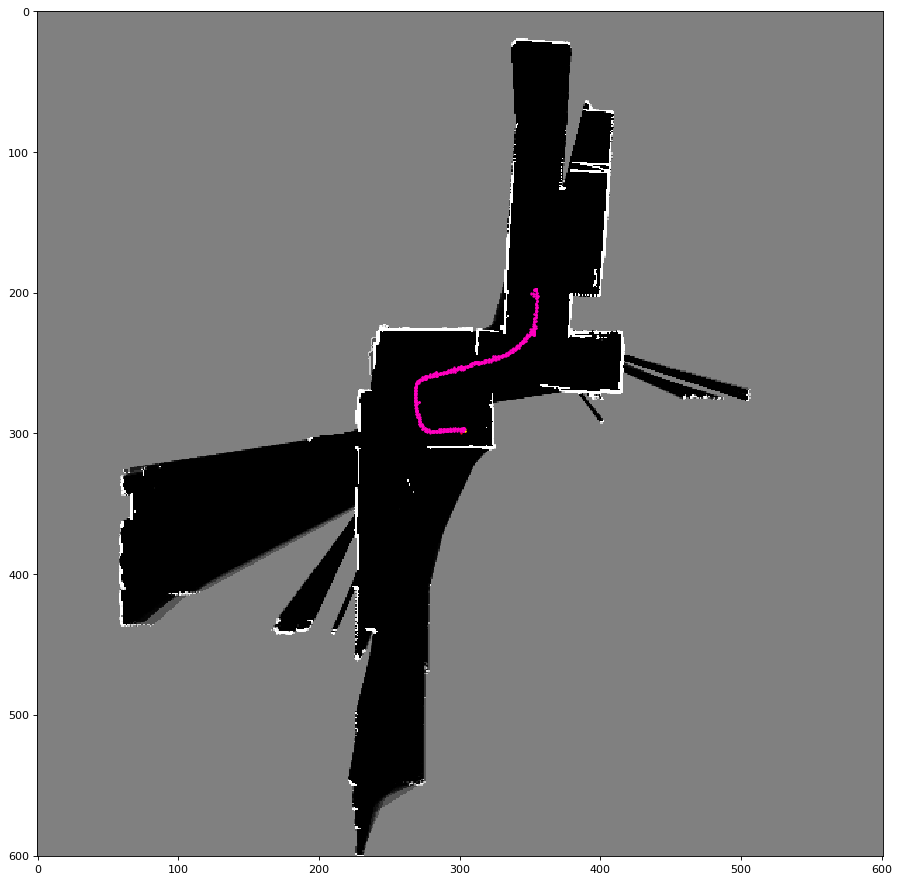

In [6]:
import pylab
indices = slam.coordinate_to_map_index(np.array(states))
plot_map(slam.map_prob, [indices[::5, 0], indices[::5, 1]], 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


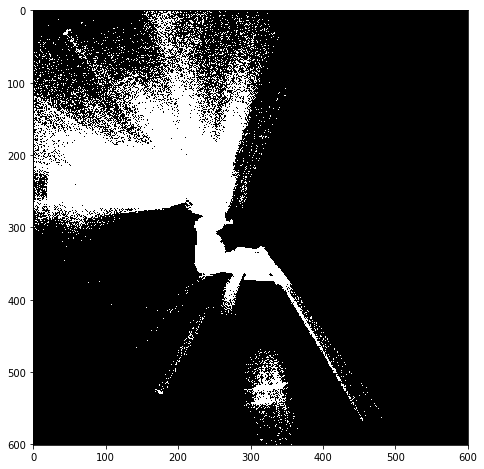

In [7]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(slam.map_texture, (1, 0, 2)))
plt.show()

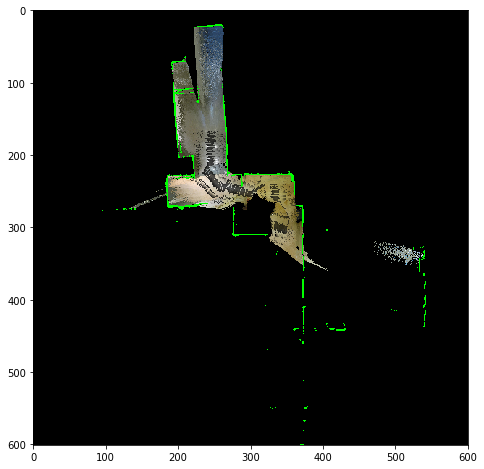

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(slam.map_texture_trimmed)
plt.show()